In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
from itertools import combinations
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

### Parameters

In [12]:
# Seed for random sampling (Rustamov)
seed_ = 42

# Paths for embedding files and mesh files
embeds_path = './results'
shapes_path = './models'

# Number of histograms and sample proportion for each region (Rustamov)
m = 1
prop = 0.3

# Type of metric for computing distances
metric_ = 'euclidean'

### File & data manipulation functions

In [13]:
def name(filename, eigs=False):
    """
    Returns shape name from a filepath
    """
    if eigs:
        return os.path.split(filename)[1].split('.')[0]
    else:
        return os.path.split(filename)[1][:-4].split('.')[0]

def missing(embeds, shapes):
    """
    Given a list of embedding filenames and a list of shapes filenames, returns a list of missing elements between those two (symmetric difference)
    """
    shapes_names = [name(i, eigs=False) for i in shapes]
    embeds_names = [name(i, eigs=True) for i in embeds]
    misses = list(set(shapes_names).symmetric_difference(set(embeds_names)))
    return sorted(misses)

def dim(filename):
    """
    Given an embedding filename, returns how many eigs were supposedly computed
    """
    return int(os.path.split(filename)[1][:-4].split('.')[-2])

def matrixGPS(filename):
    """
    Returns GPS matrix read from a file
    """
    GPS = []
    with open(filename, 'r') as file:
        for l in file:
            values = l.strip().split()
            try:
                v = [float(i) for i in values]
            except ValueError:
                continue
            assert(len(v) == dim(filename)), 'Wrong dimension in' + filename
            GPS.append(v)
    return np.array(GPS)

def shapeDNA(filename):
    """
    Returns ShapeDNA vector read from a file
    """
    dna = []
    with open(filename, 'r') as file:
        for l in file:
            dna.append(float(l.strip()))
    assert(len(dna) == dim(filename)), 'Wrong dimension in' + filename
    return np.array(dna)
    
def regions(GPS):
    """
    Returns region indexes (0 to m - 1) for each vertex in GPS
    """
    global m
    distances = [np.linalg.norm(v) for v in GPS]
    d_min = min(distances)
    delta = (max(distances) - d_min) / m
    
    regs = [int((d - d_min) // delta) for d in distances]
    return regs

def samples(regions, m1, m2):
    """
    Computes 2 randomly sampled point indexes from regions m1 and m2, size prop% 
    """
    global m
    global prop
    assert(m1 < m and m2 < m), 'Regions given are not valid'
    np.random.seed(seed_)
    points_m1 = (np.array(regions) == m1).nonzero()[0]
    points_m2 = (np.array(regions) == m2).nonzero()[0]
    

    sample_m1 = np.random.choice(points_m1, int(prop * len(points_m1)))
    sample_m2 = np.random.choice(points_m2, int(prop * len(points_m2)))
    return sample_m1, sample_m2

def sample(regions, m1):
    """
    Computes randomly sampled point indexes from region m1, size prop% 
    """
    global m
    global prop
    assert(m1 < m), 'Region given are not valid'
    np.random.seed(seed_)
    points_m1 = (np.array(regions) == m1).nonzero()[0]
    sample_m1 = np.random.choice(points_m1, int(prop * len(points_m1)))
    
    return sample_m1

# def distances(GPS1, GPS2, regions1, regions2, m1, m2, metric='euclidean'):
#     """
#     Computes pair-wise distances between sampled points of GPS1 and GPS2 for regions m1 and m2 respectively
#     """
#     m1_indices = sample(regions1, m1)
#     m2_indices = sample(regions2, m2)
#     GPS_m1 = GPS1[m1_indices]
#     GPS_m2 = GPS2[m2_indices]
#     return cdist(GPS_m1, GPS_m2, metric=metric).flatten()

def distances(GPS, regions, m1, m2, metric='euclidean'):
    """
    Computes pair-wise distances between sampled points of GPS for regions m1 and m2
    """
    m1_indices, m2_indices = samples(regions, m1, m2)
    GPS_m1 = GPS[m1_indices]
    GPS_m2 = GPS[m2_indices]
    return cdist(GPS_m1, GPS_m2, metric=metric).flatten()

def myargwhere(l, value):
    """
    Returns indexes {i} in l where l[i] == value
    """
    return (np.array(l) == value).nonzero()[0]

def dim_reduction(X, method='tsne'):
    """
    Wrapper for different dimensionality reduction methods to plot found descriptors
    """
    if method == 'tsne':
        model = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=seed_)
        coords_2d = model.fit_transform(X)
        return coords_2d[:, 0], coords_2d[:, 1]
    elif method == 'pca':
        model = PCA(n_components=2)
        coords_2d = model.fit_transform(X)
        return coords_2d[:, 0], coords_2d[:, 1]
    elif method == 'mds':
        model = MDS(n_components=2, max_iter=300, random_state=seed_)
        coords_2d = model.fit_transform(X)
        return coords_2d[:, 0], coords_2d[:, 1]
    else:
        raise Exception('Method is not valid')
        
def scatter_annotated(x, y, labels):
    """
    Plots a labeled scatter plot in matplotlib
    """
    fig, ax = plt.subplots(figsize=(10,10))
    for g in range(len(np.unique(labels))):
        label_i = np.unique(labels)[g]
        i = myargwhere(labels, label_i)
        ax.scatter(x[i], y[i], label=label_i)
    ax.legend()
    plt.show()

### Data importing

In [14]:
assert(prop <= 1.0 and prop > 0.0), 'Proportion is not valid'
embeds = glob.glob(embeds_path + '/*.txt')
shapes = glob.glob(shapes_path + './**/*.obj')

# Split filename lists by descriptor
embeds_gps = []
embeds_shapedna = []
for i in embeds:
    if 'shapeDNA' in i:
        embeds_shapedna.append(i)
    else:
        embeds_gps.append(i)

miss = missing(embeds, shapes)
print('{} embeddings missing :\n'.format(len(miss)))
print(*miss, sep='\n')

79 embeddings missing :

1
10
100
11
12
13
15
16
17
19
3
31
33
36
4
41
42
43
44
45
46
47
48
49
5
50
51
52
53
54
55
56
57
58
59
6
60
61
62
63
64
65
66
67
68
69
7
70
71
73
74
75
76
77
78
79
8
80
81
82
83
84
85
86
87
88
89
9
90
91
92
93
94
95
96
97
98
99
camel-collapse-01


### ShapeDNA
We visualize from the least common descriptor length for various methods

In [15]:
len(embeds_gps)

79

In [16]:
# X stores ShapeDNA vectors, y stores complete labels (elephant-gallop-01, camel-collapse-20, etc.) and y_simple general labels (cat, face, etc.)
X = []
y_full = []
y_mid = []
y_simple = []
min_d = 20


int_table = str.maketrans(dict.fromkeys('0123456789'))
for f in embeds_shapedna:
    v = shapeDNA(f)
    X.append(v)
    if len(v) < min_d:
        min_d = len(v)
    meshname = name(f)
    y_full.append(meshname)
    y_simple.append(meshname.split('-')[0])
    y_mid.append(meshname.translate(int_table).strip('-').replace('-reference', '').split('--', 1)[0])

# truncate to maximum common spectrum depth
X_trunc = [x[:min_d] for x in X]
X_trunc = np.array(X_trunc)

print(X_trunc.shape)

(79, 15)


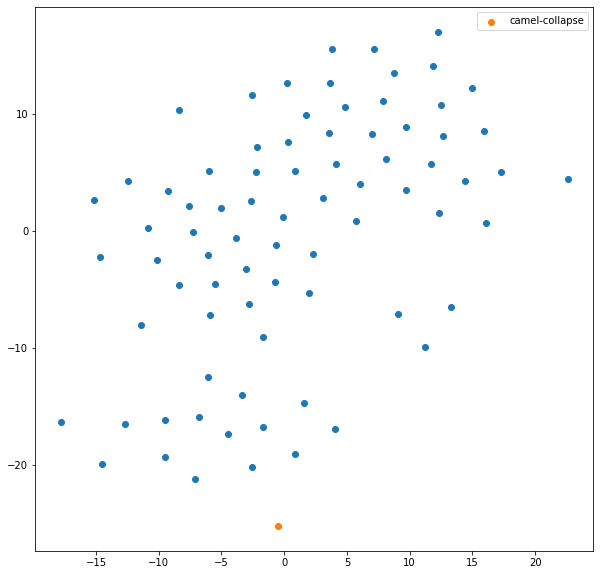

In [17]:
x_tsne, y_tsne = dim_reduction(X_trunc, method='tsne')
scatter_annotated(x_tsne, y_tsne, y_mid)

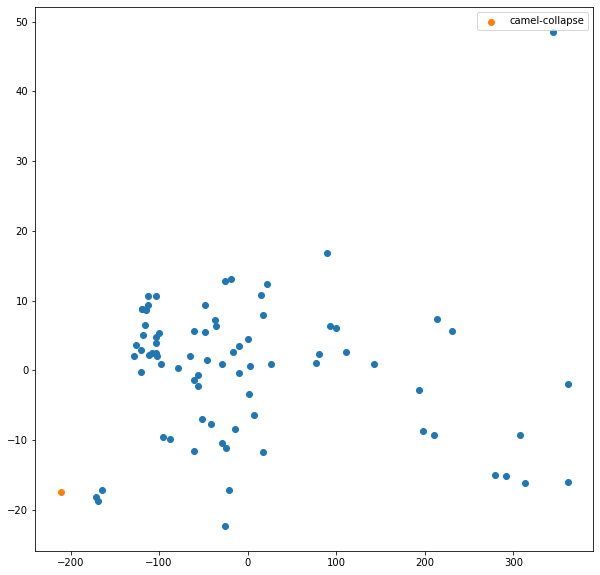

In [18]:
x_pca, y_pca = dim_reduction(X_trunc, method='pca')
scatter_annotated(x_pca, y_pca, y_mid)

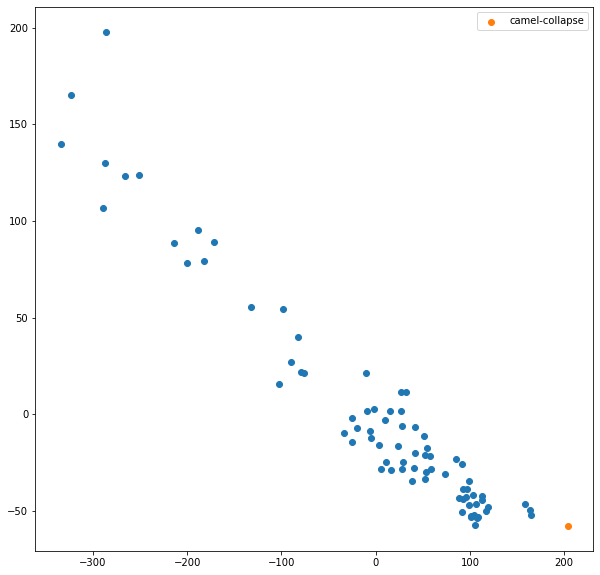

In [19]:
x_mds, y_mds = dim_reduction(X_trunc, method='mds')
scatter_annotated(x_mds, y_mds, y_mid)

### GPS embeddings

As we compare histograms, unconsistent dimensions accross GPS embeddings is not an issue to compare them

#### Histogram comparison within same base shape

(5619, 15)
2839225


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


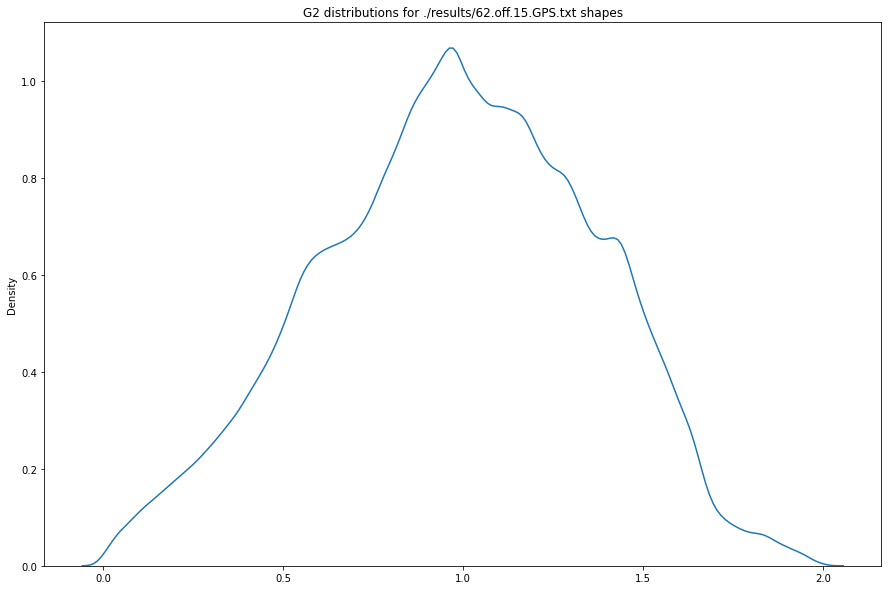

(5614, 15)
2832489


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


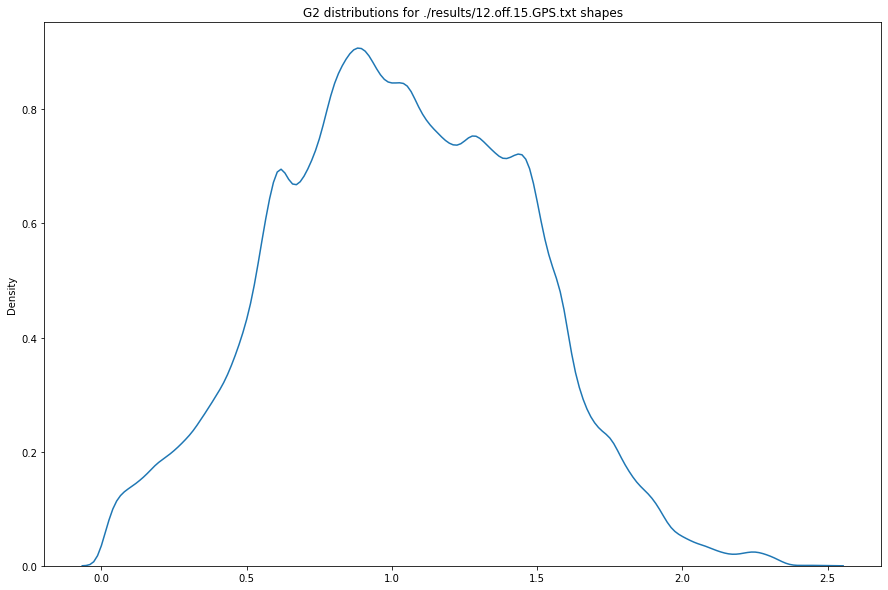

(15910, 15)
22771984


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


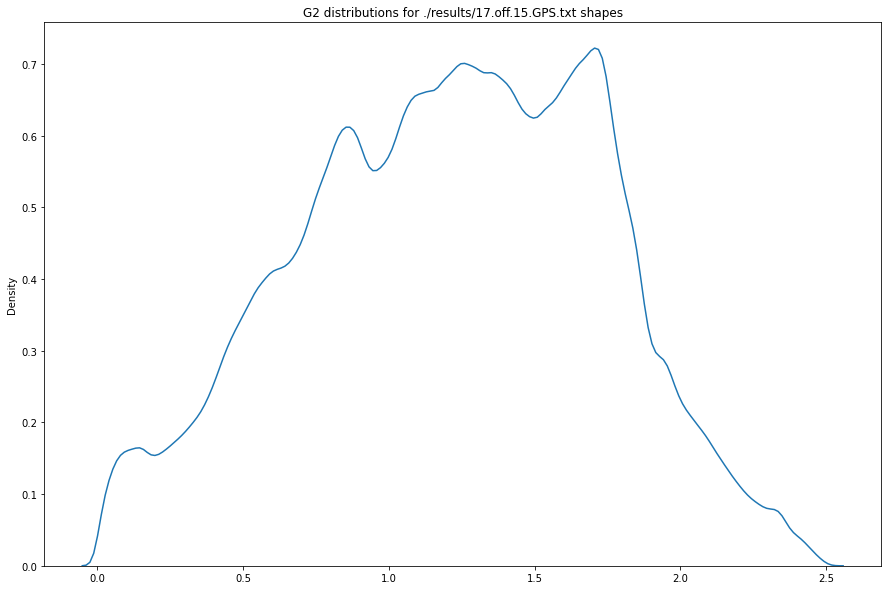

(6370, 15)
3648100


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


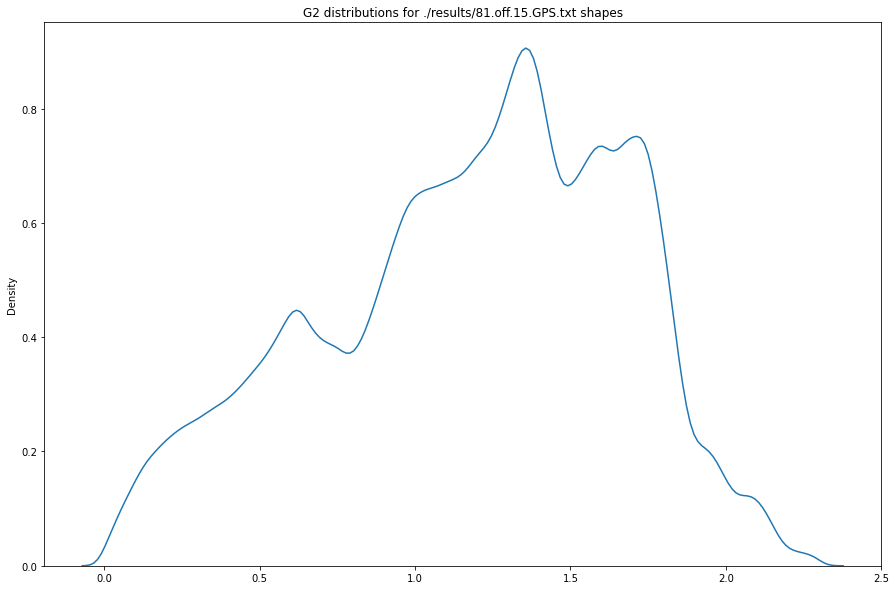

(6850, 15)
4218916


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


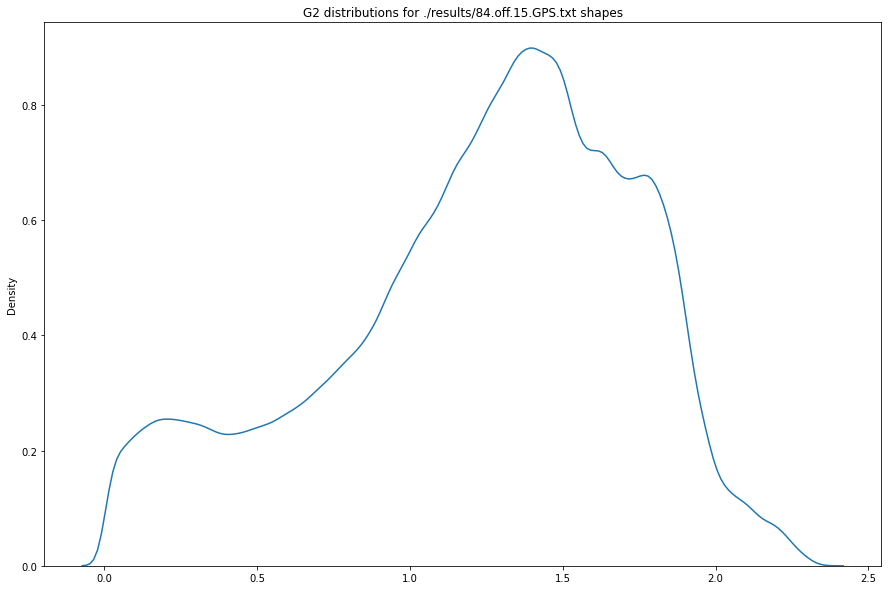

(7351, 15)
4862025


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


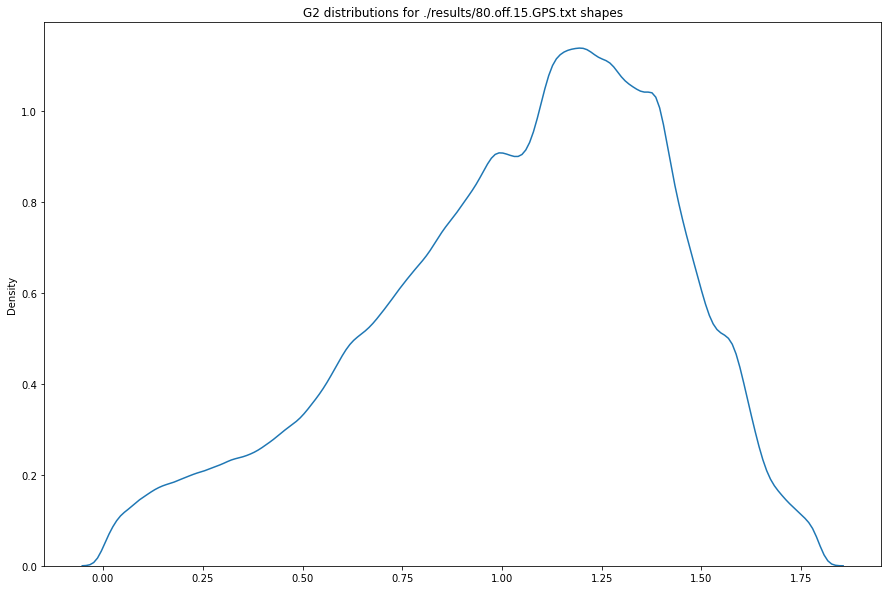

(3110, 15)
868624


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


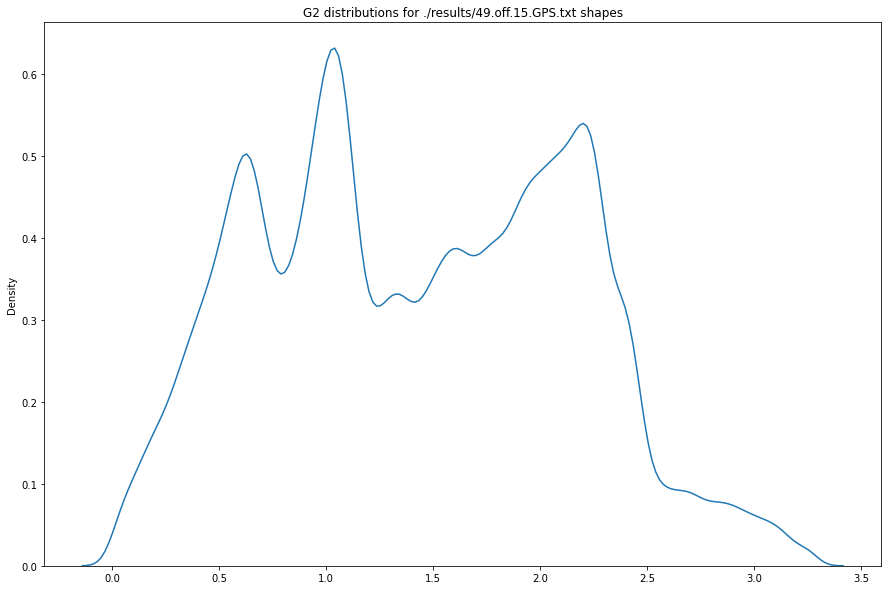

(7470, 15)
5017600


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


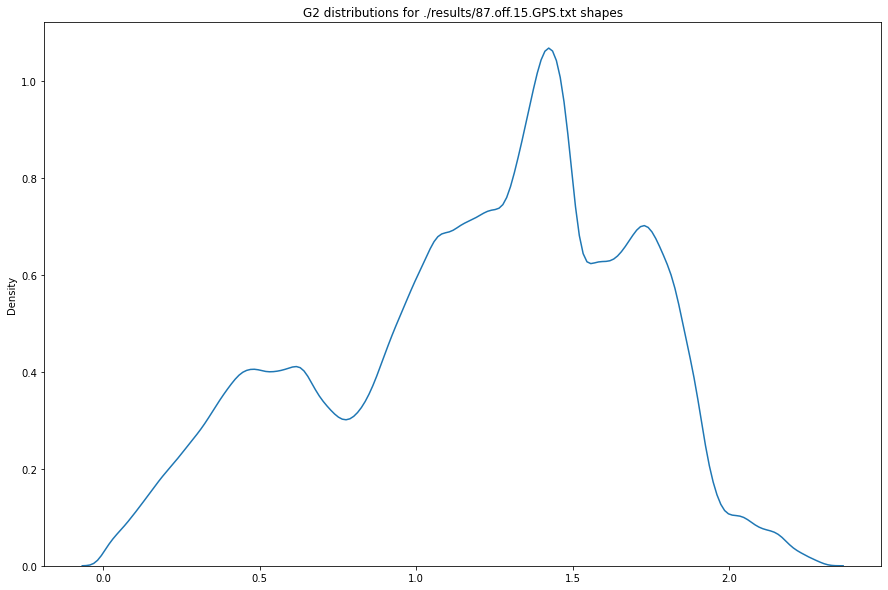

(5176, 15)
2408704


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


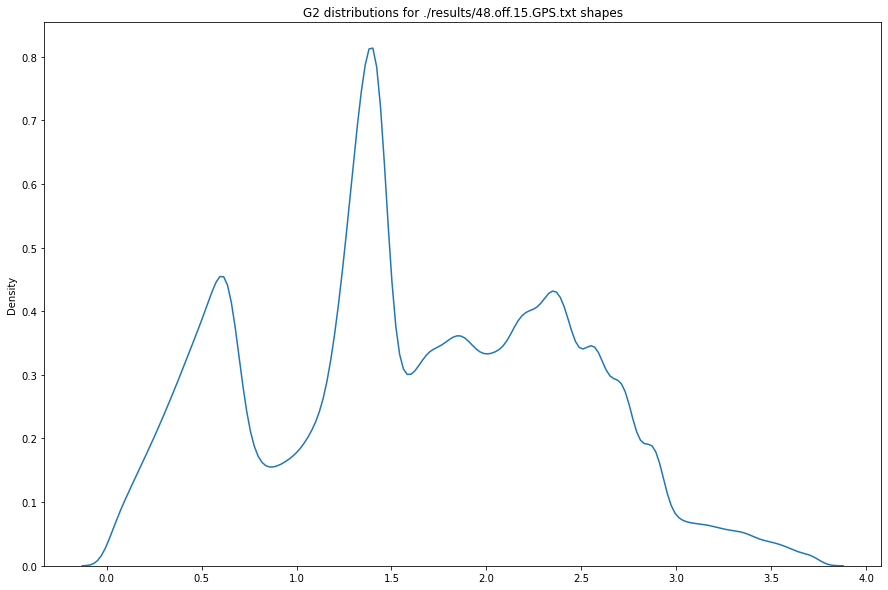

(6448, 15)
3740356


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


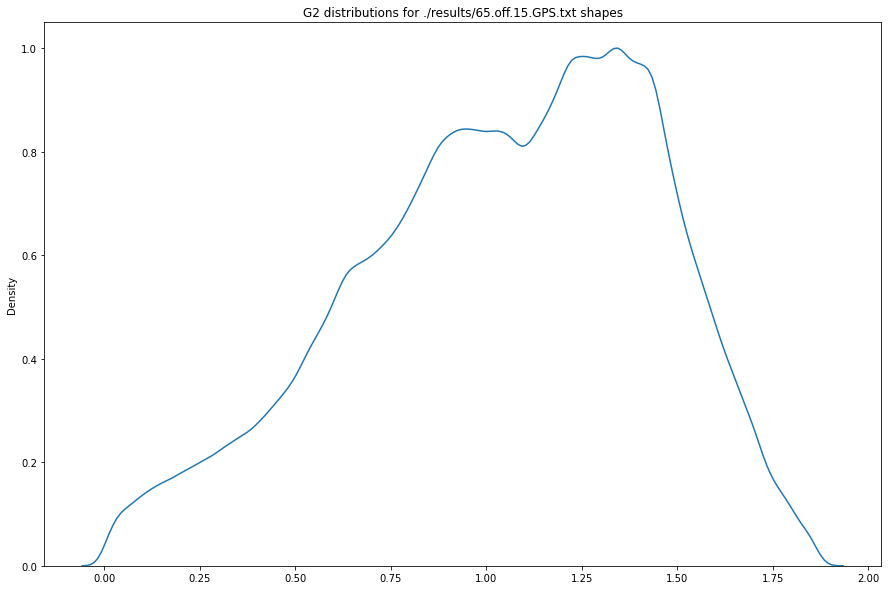

(6797, 15)
4153444


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


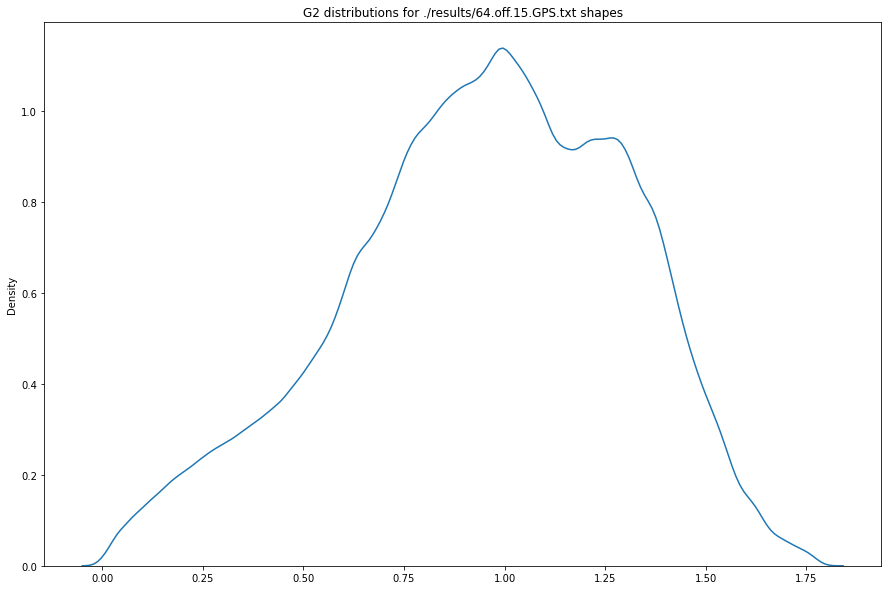

(2394, 15)
514089


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


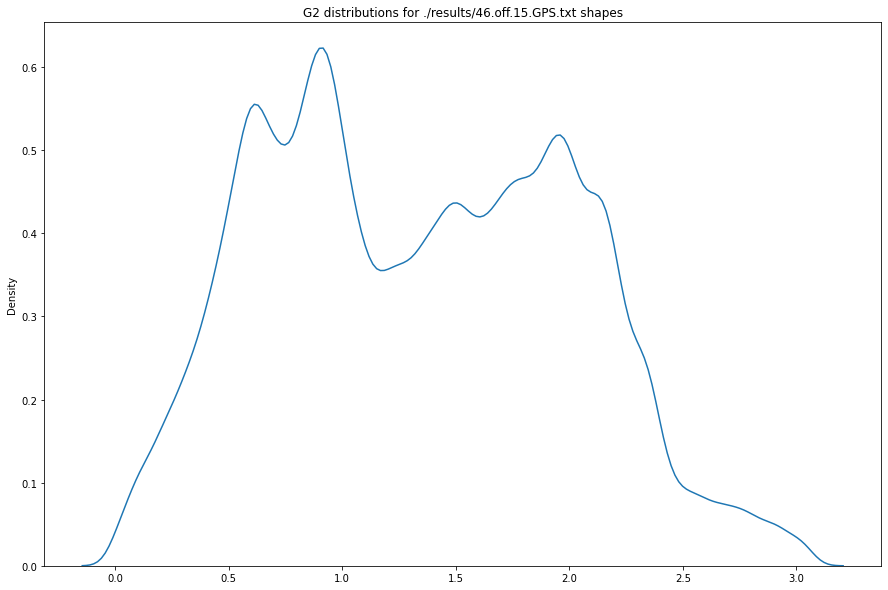

(7413, 15)
4941729


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


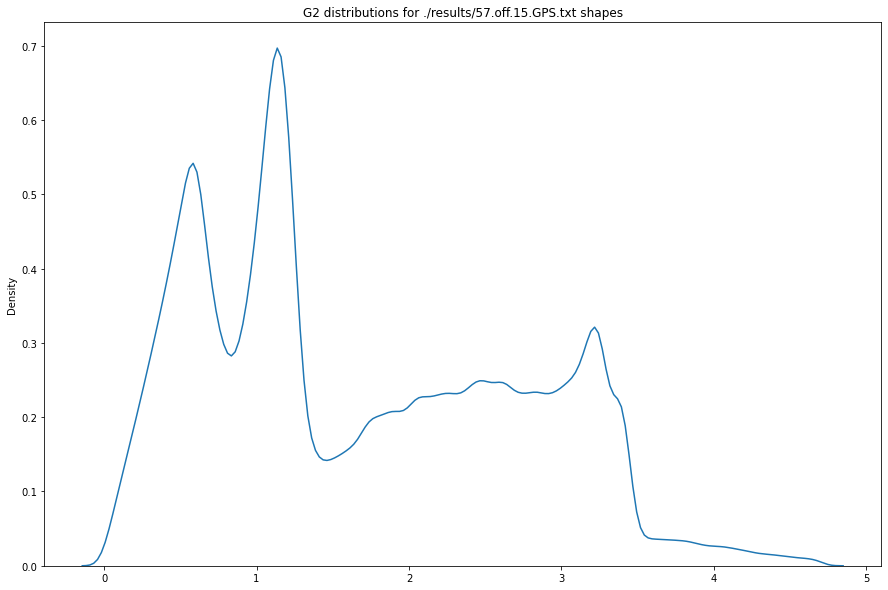

(8167, 15)
5997601


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


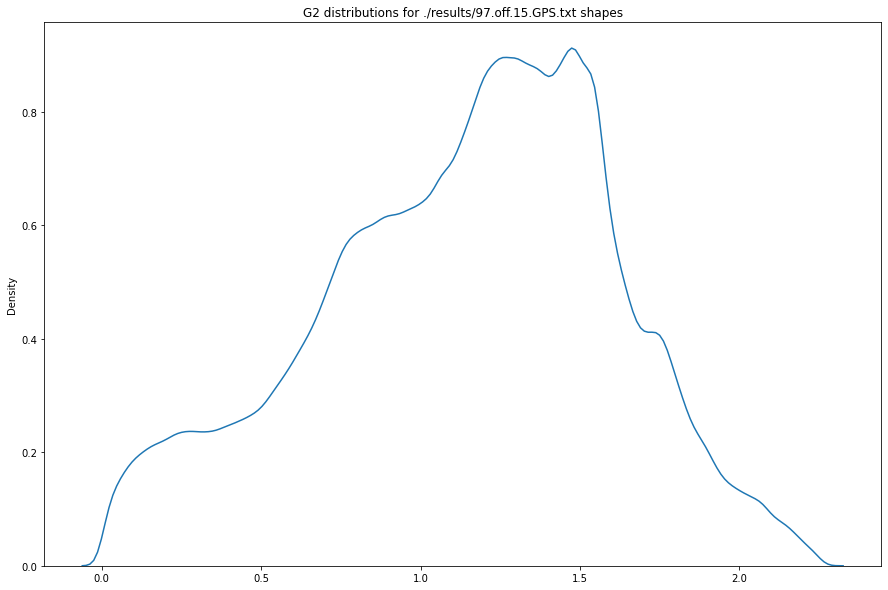

(6587, 15)
3900625


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


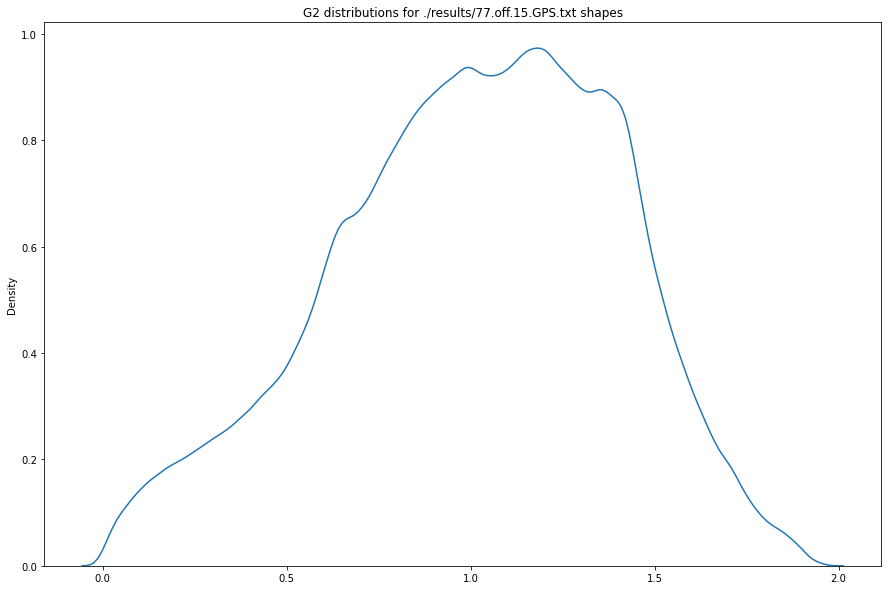

(6701, 15)
4040100


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


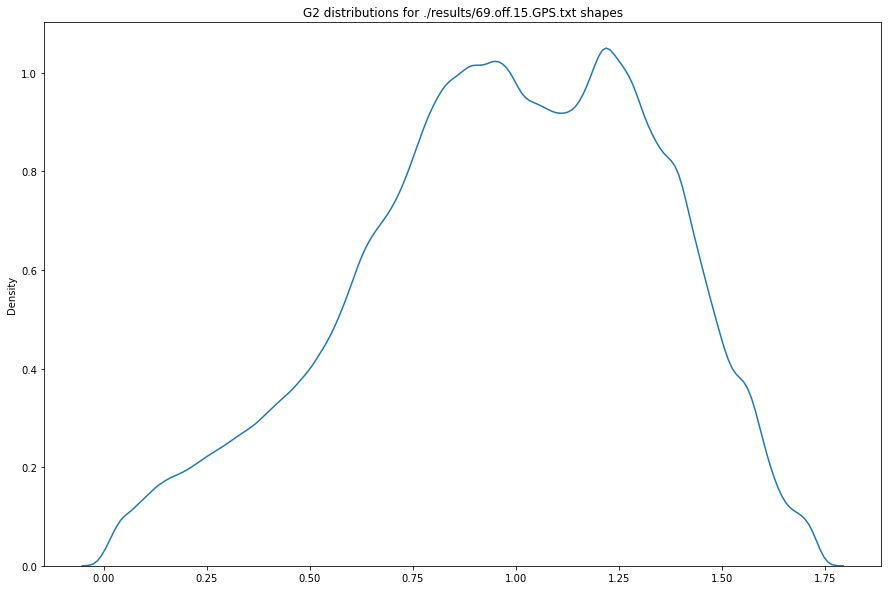

(11015, 15)
10916416


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


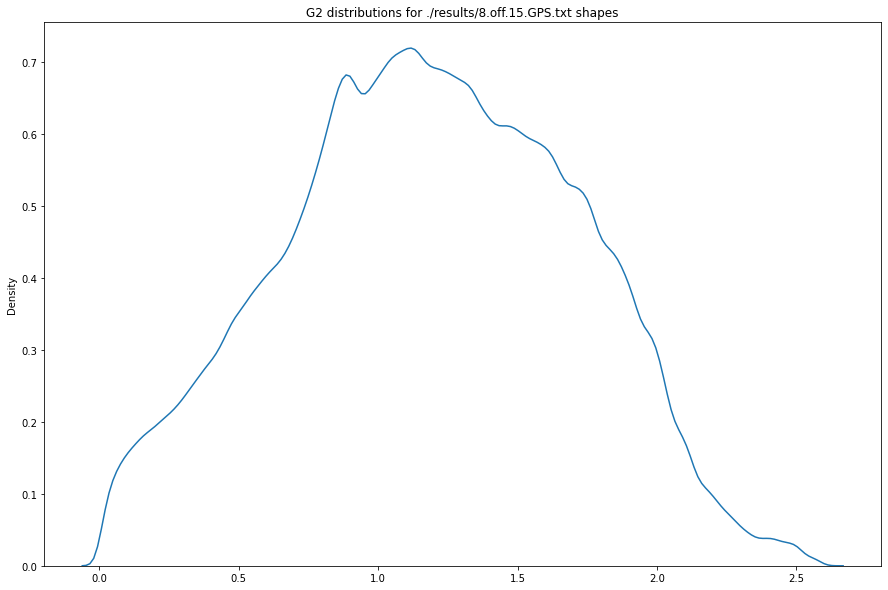

(9508, 15)
8133904


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


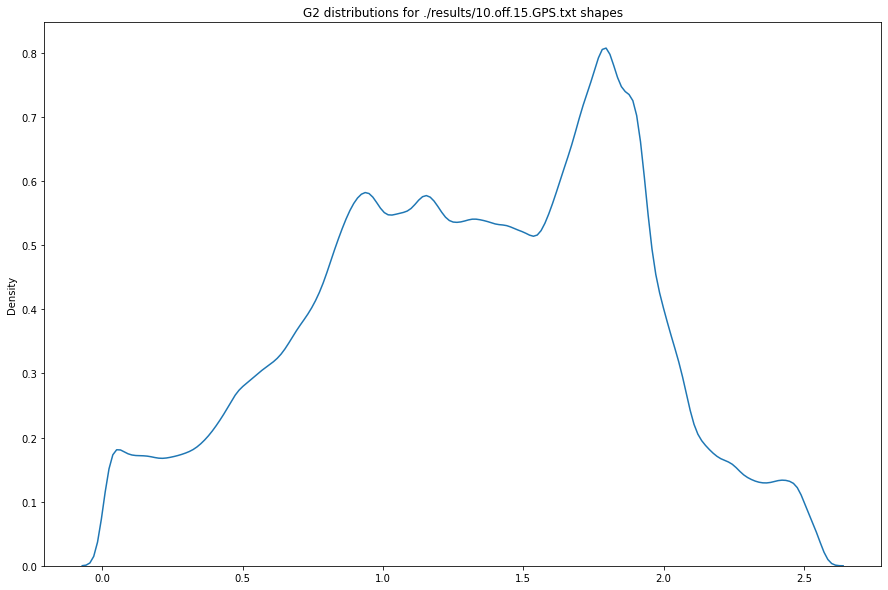

(6689, 15)
4024036


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


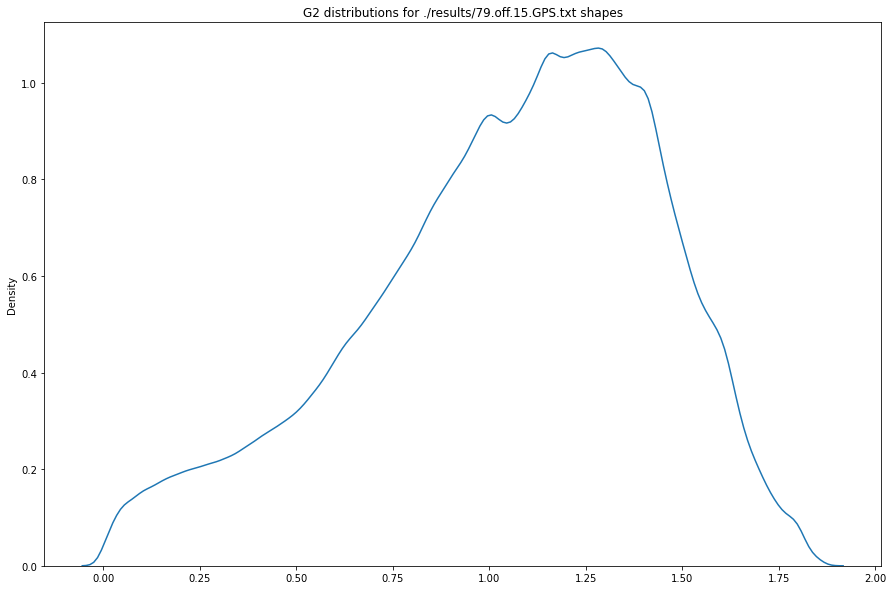

(21887, 15)
43099225


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


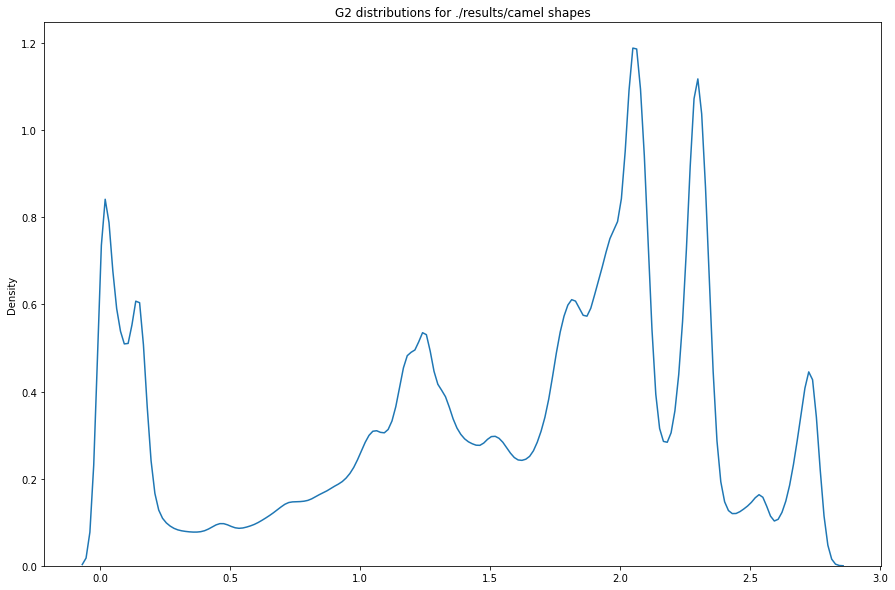

(8640, 15)
6713281


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


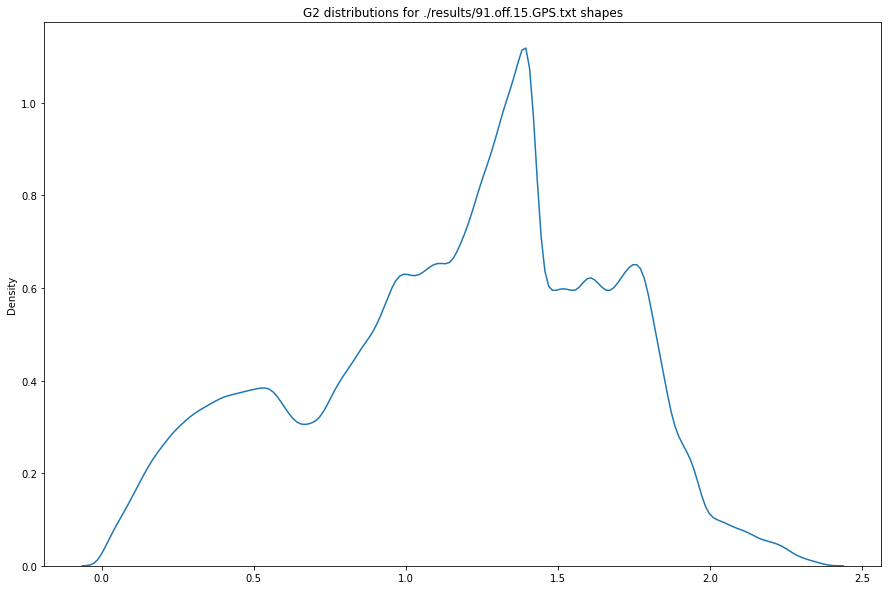

(8679, 15)
6775609


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


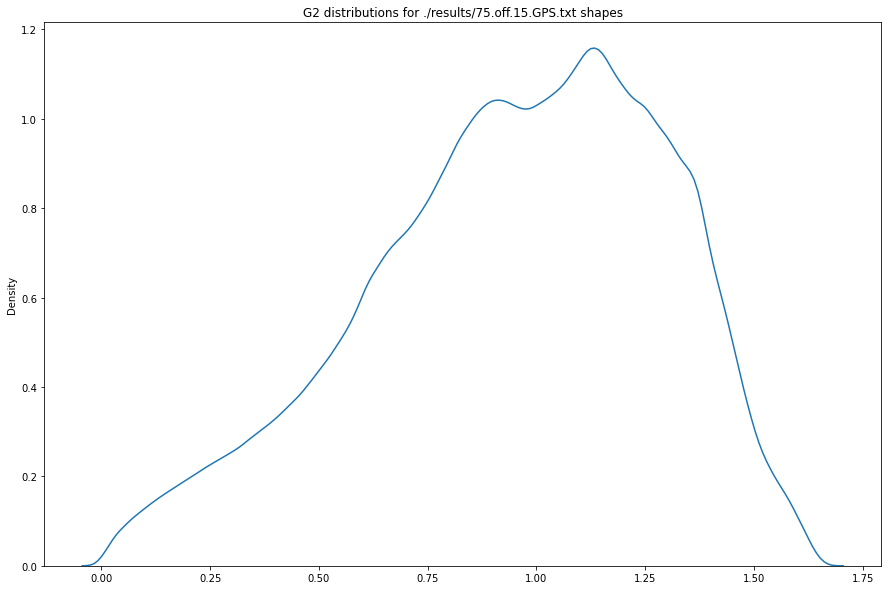

(9076, 15)
7409284


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


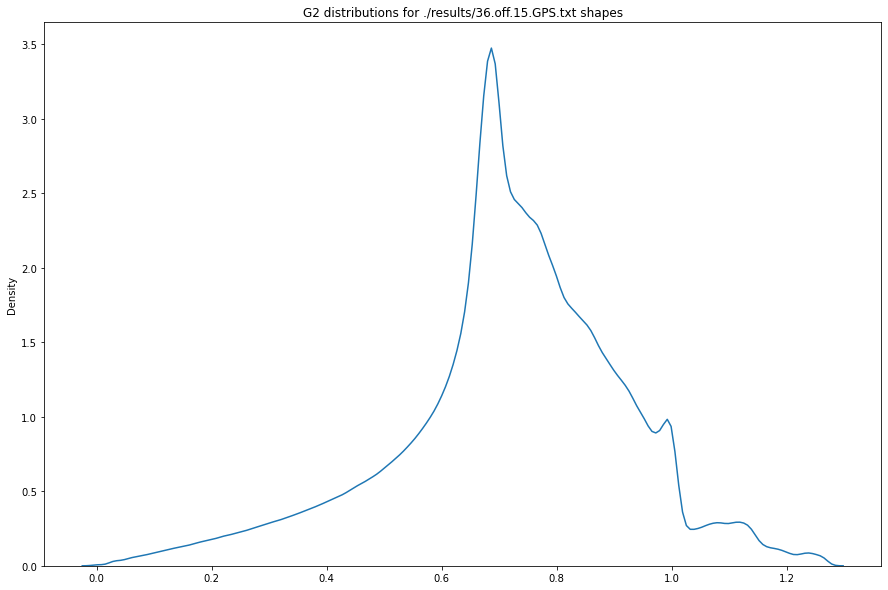

(8388, 15)
6330256


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


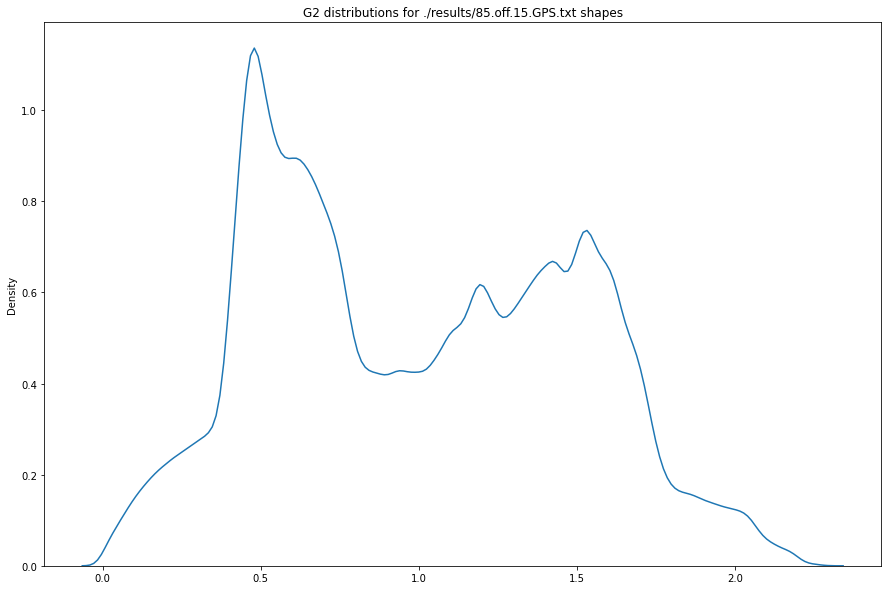

(7349, 15)
4857616


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


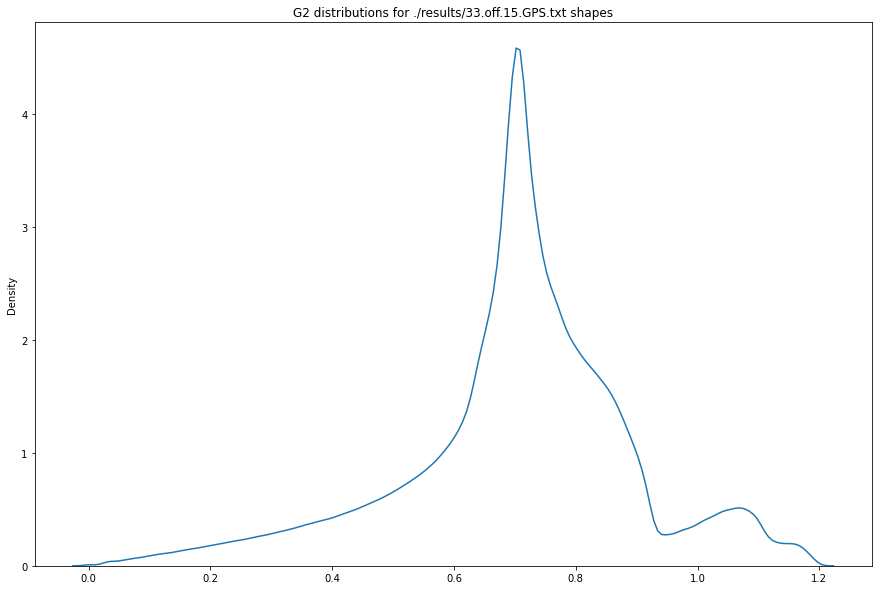

(5109, 15)
2347024


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


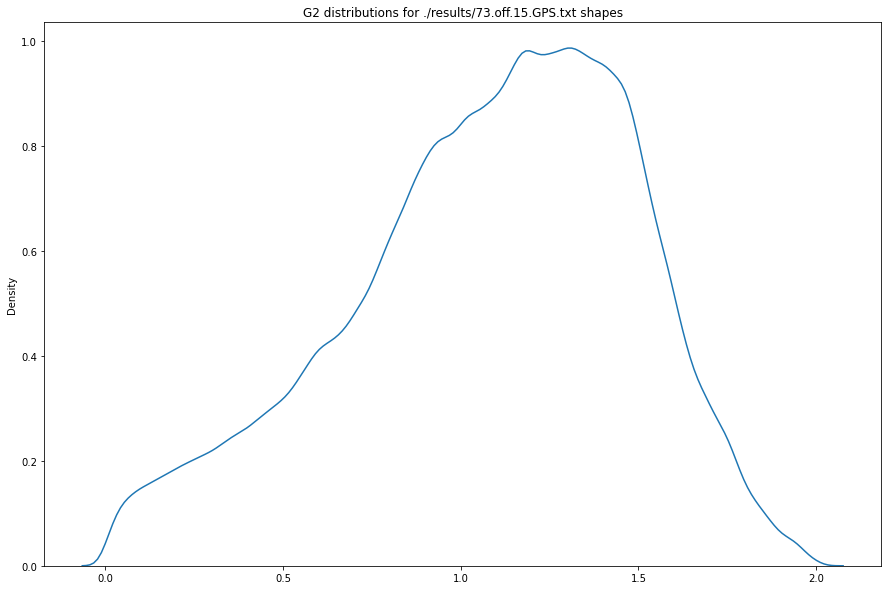

(8216, 15)
6071296


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


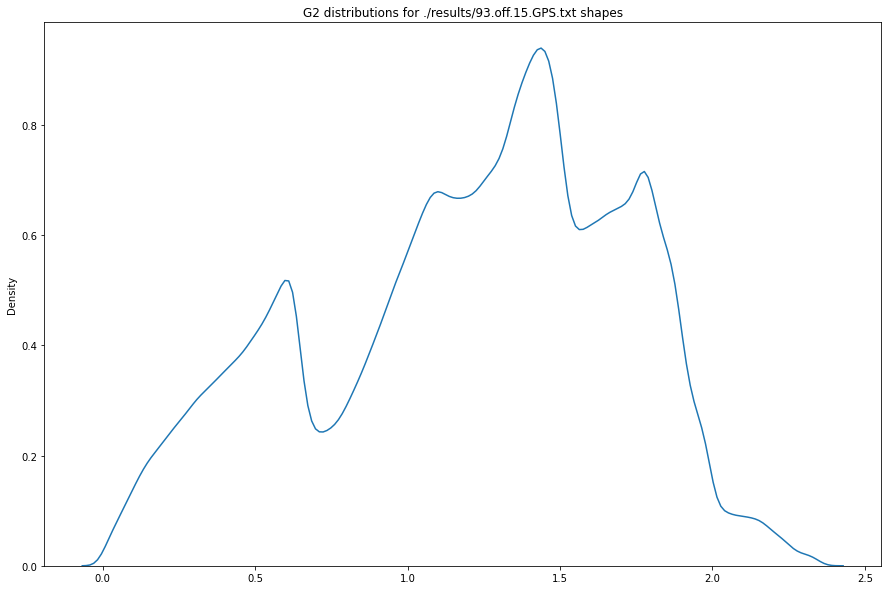

(15477, 15)
21548164


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


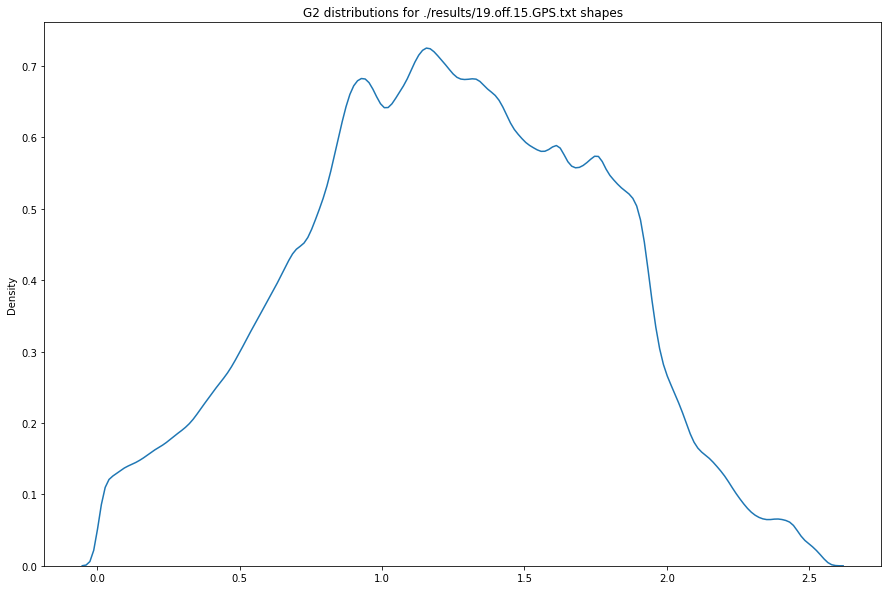

(5044, 15)
2286144


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


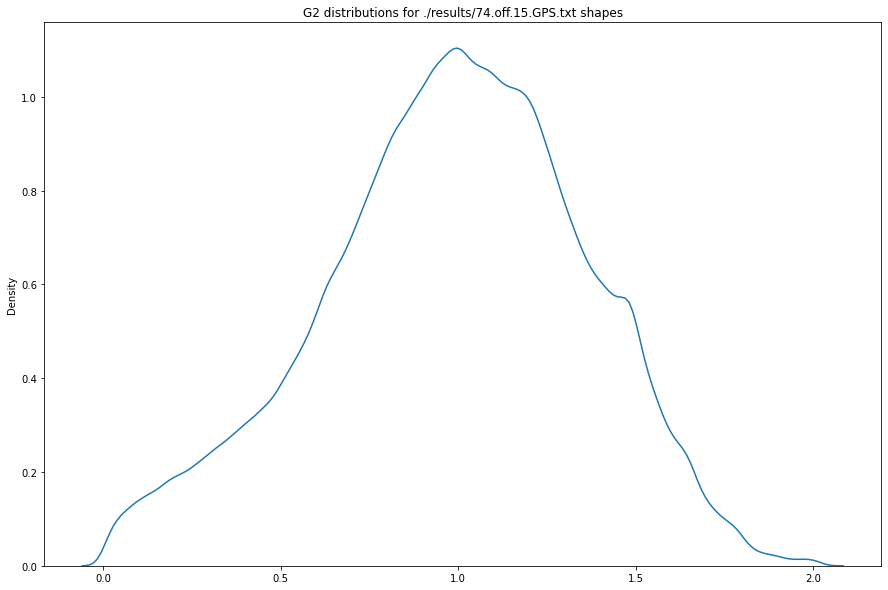

(7016, 15)
4426816


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


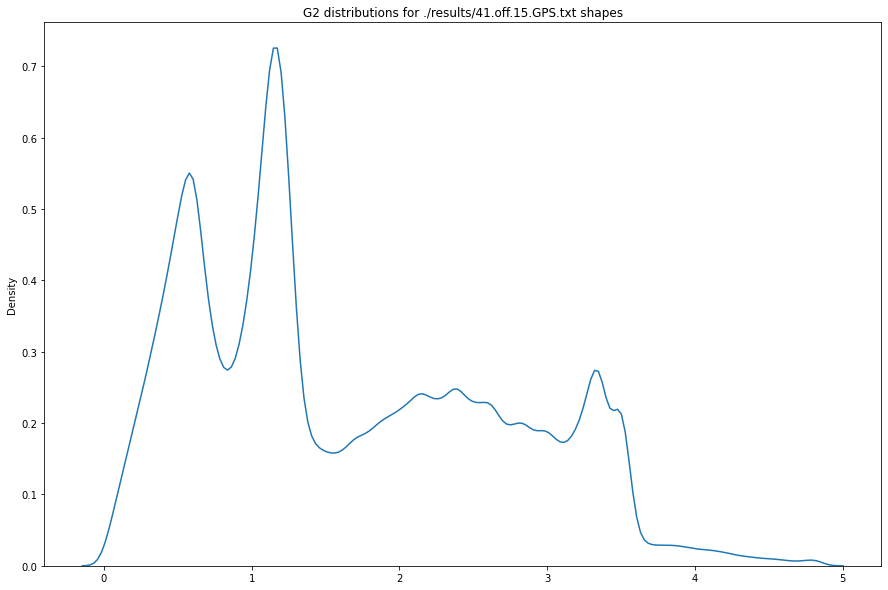

(8064, 15)
5846724


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


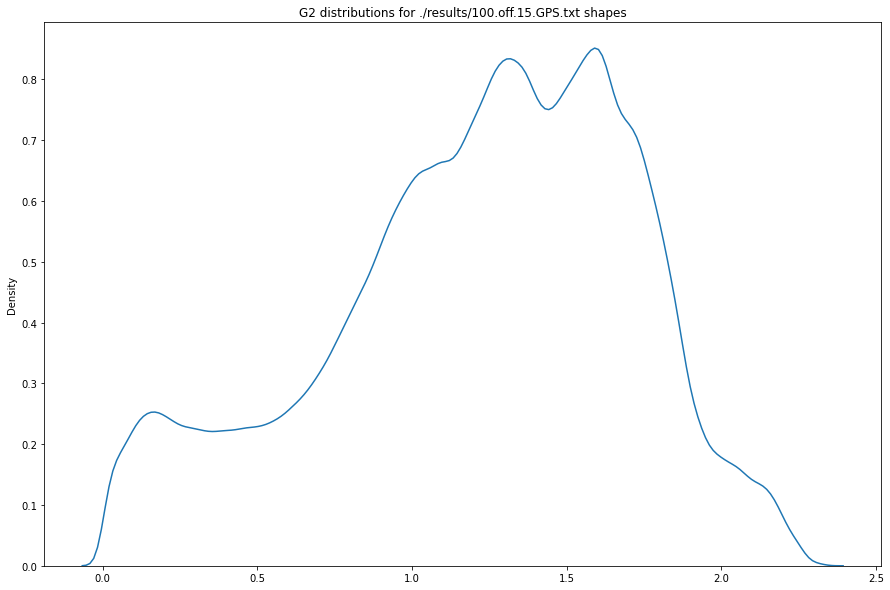

(13703, 15)
16892100


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


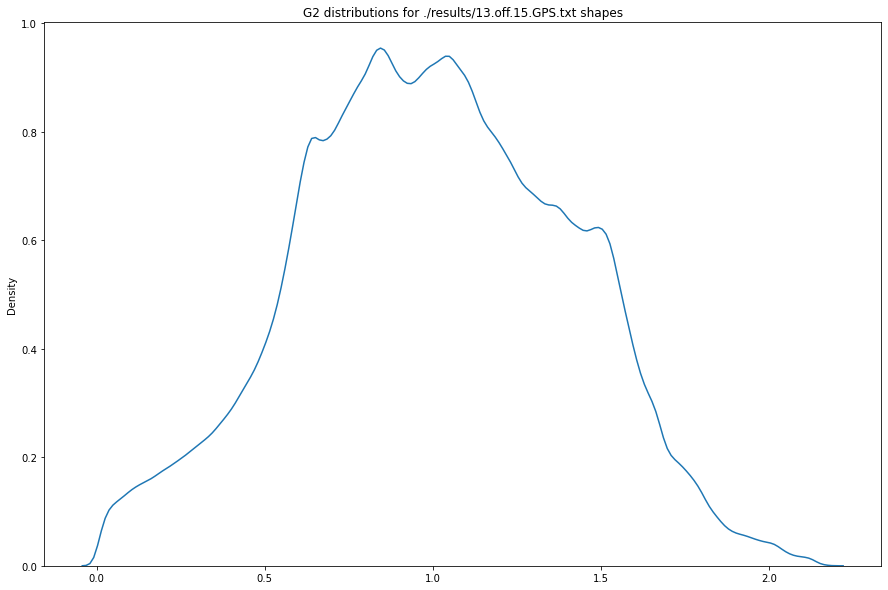

(7038, 15)
4456321


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


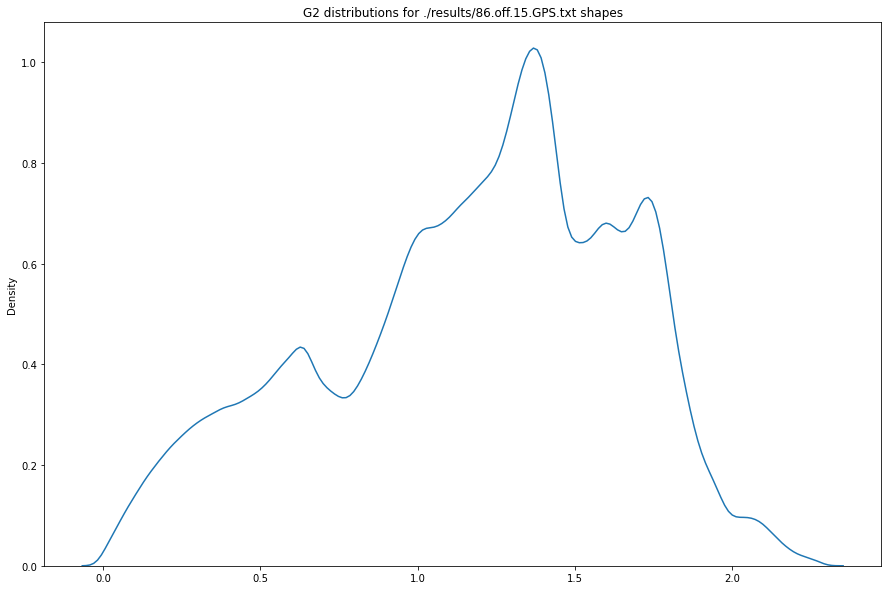

(2895, 15)
753424


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


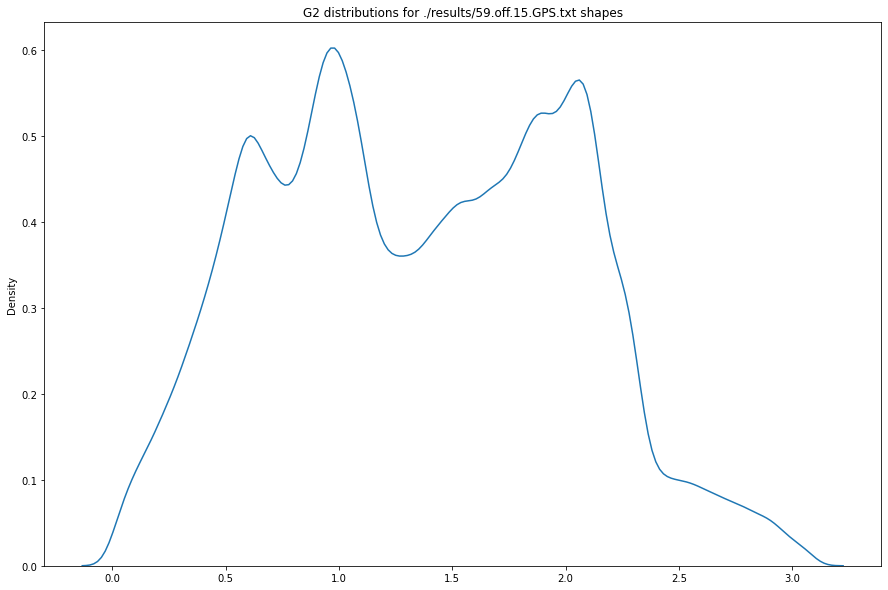

(15223, 15)
20848356


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


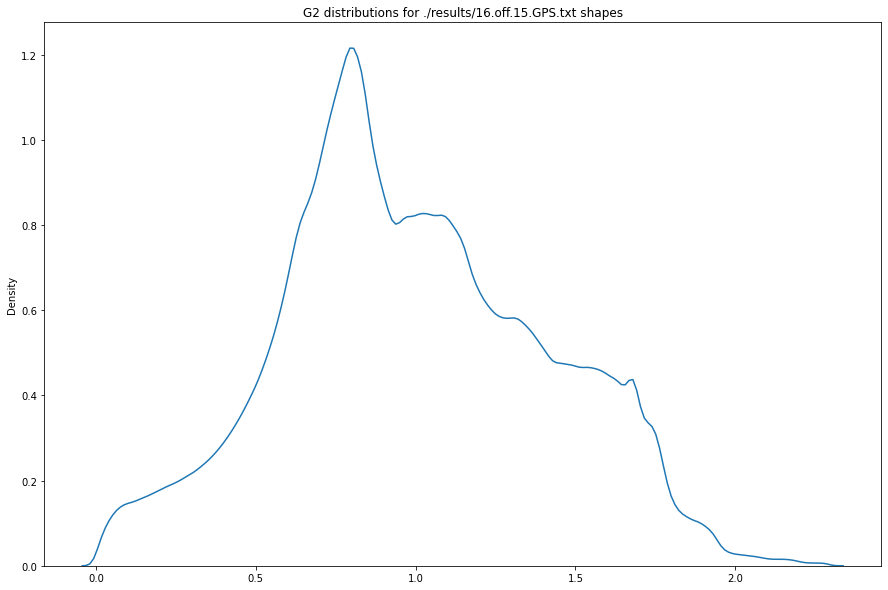

(4706, 15)
1990921


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


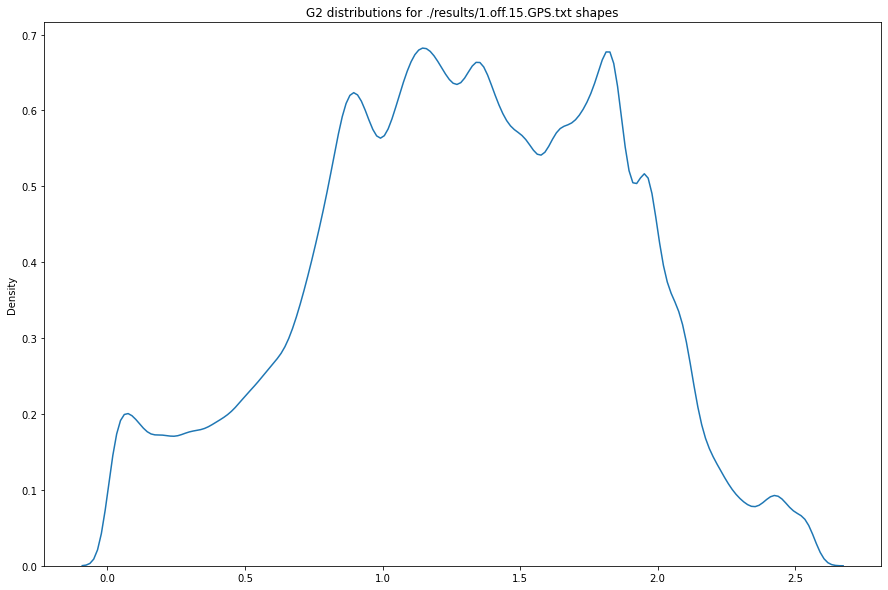

(7236, 15)
4708900


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


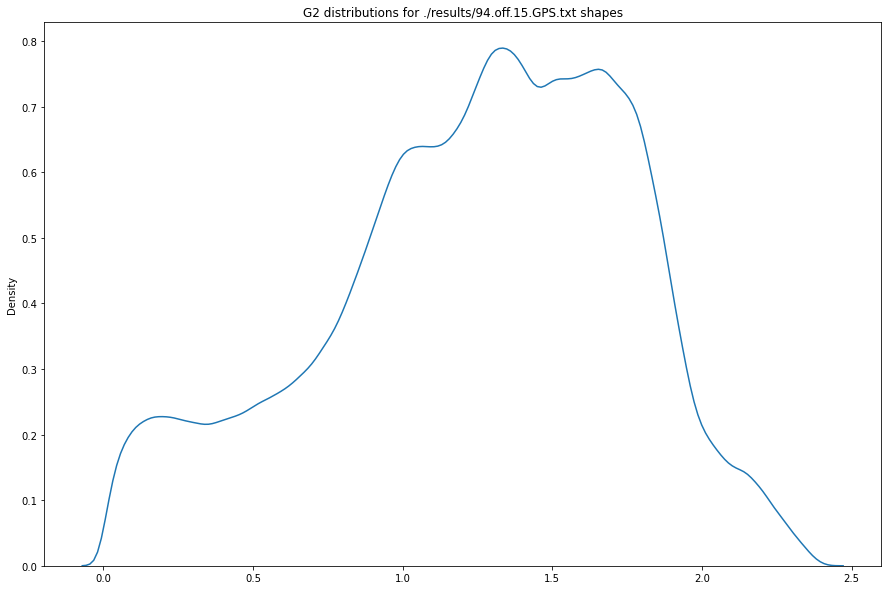

(5583, 15)
2802276


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


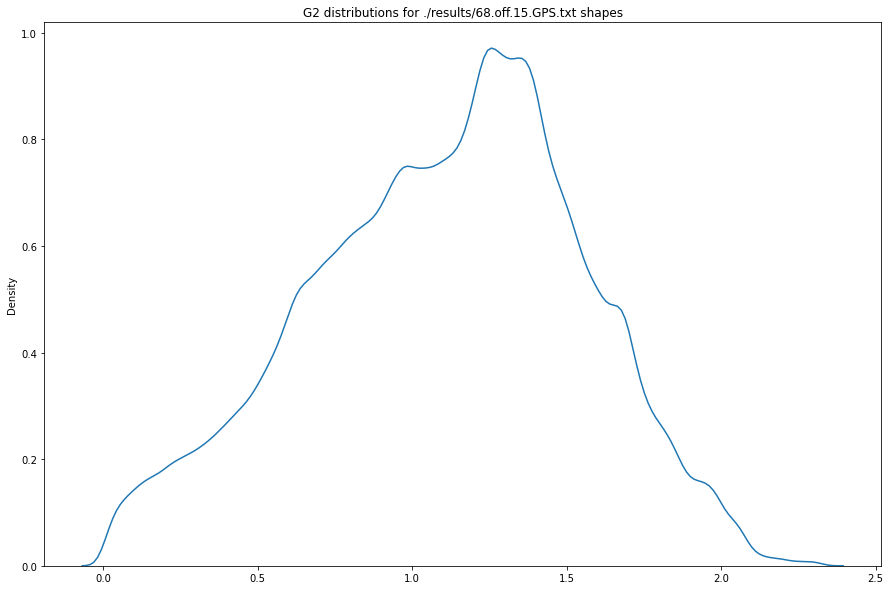

(7877, 15)
5579044


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


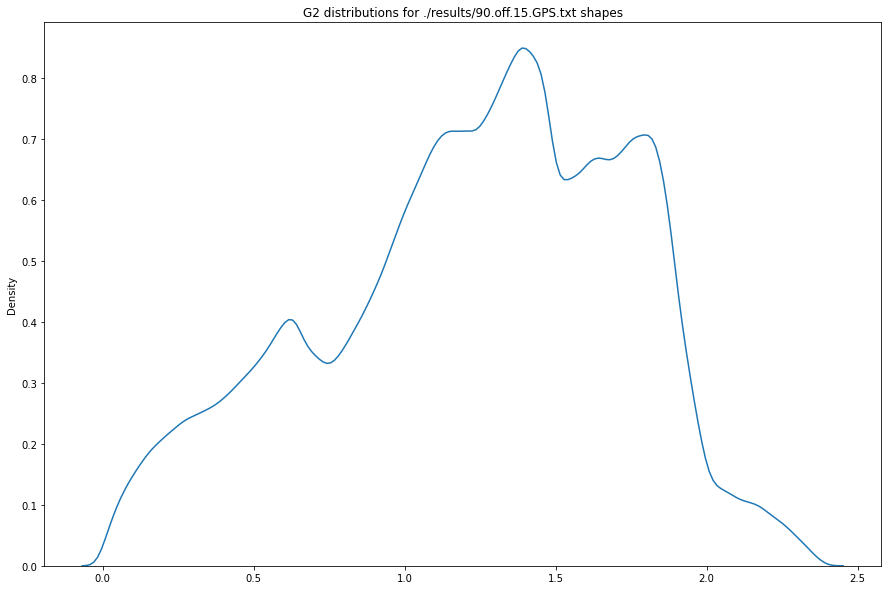

(7355, 15)
4866436


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


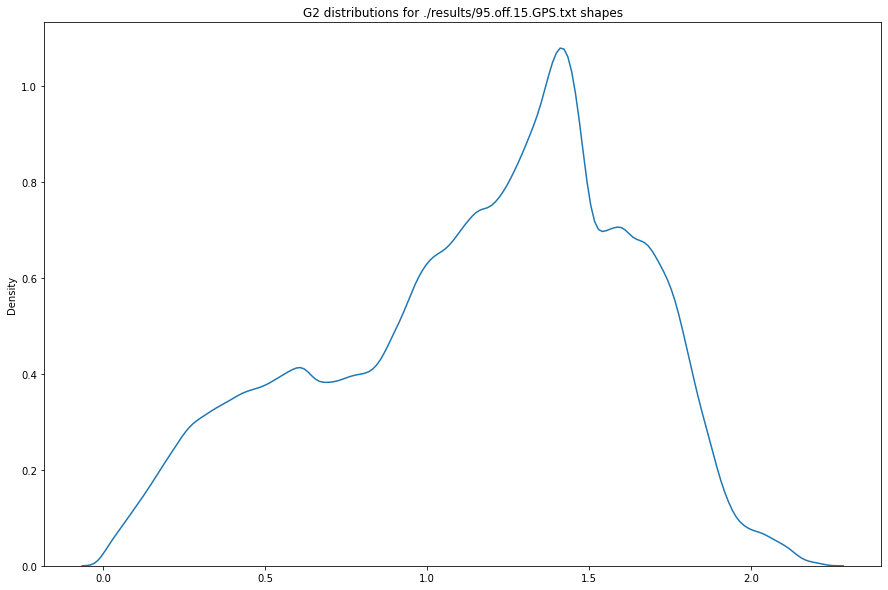

(5519, 15)
2739025


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


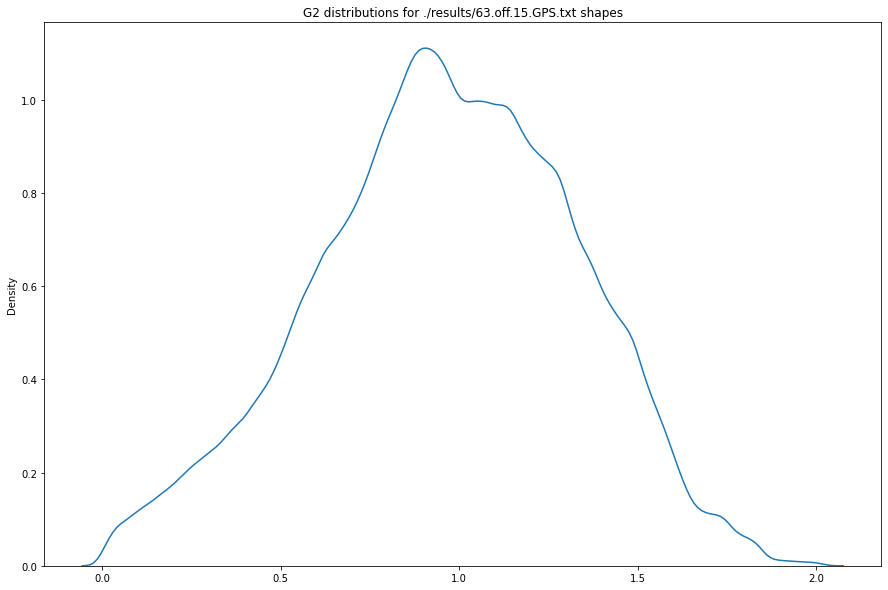

(7651, 15)
5267025


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


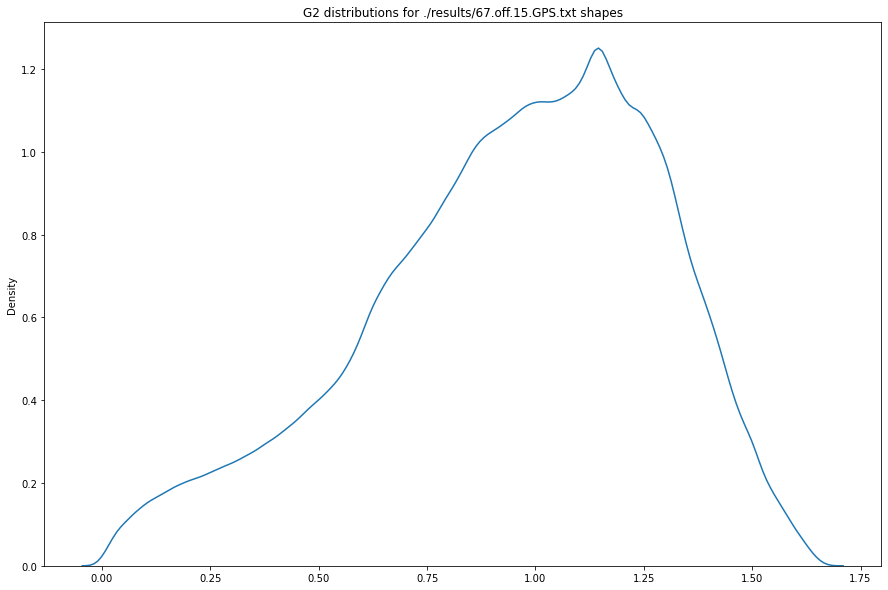

(2496, 15)
559504


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


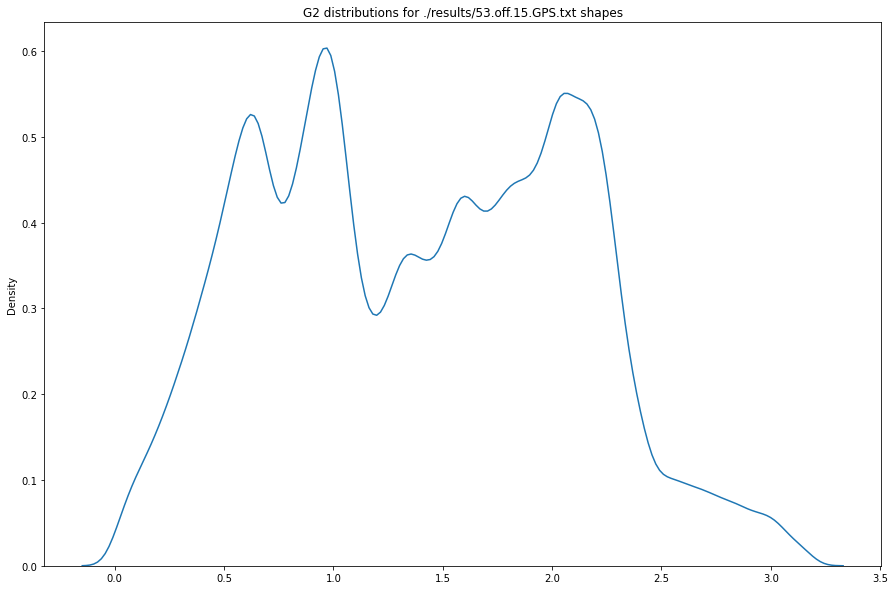

(5641, 15)
2862864


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


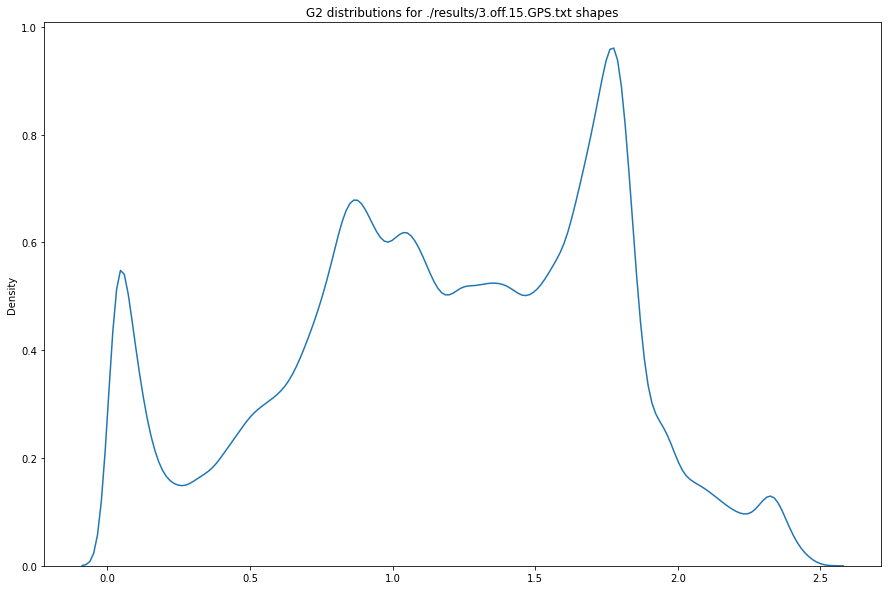

(7739, 15)
5387041


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


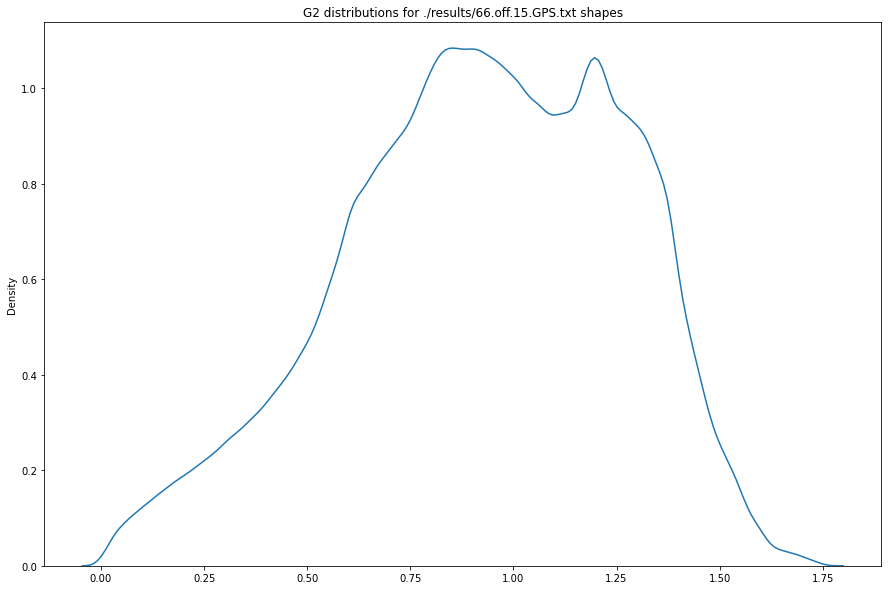

(10999, 15)
10883401


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


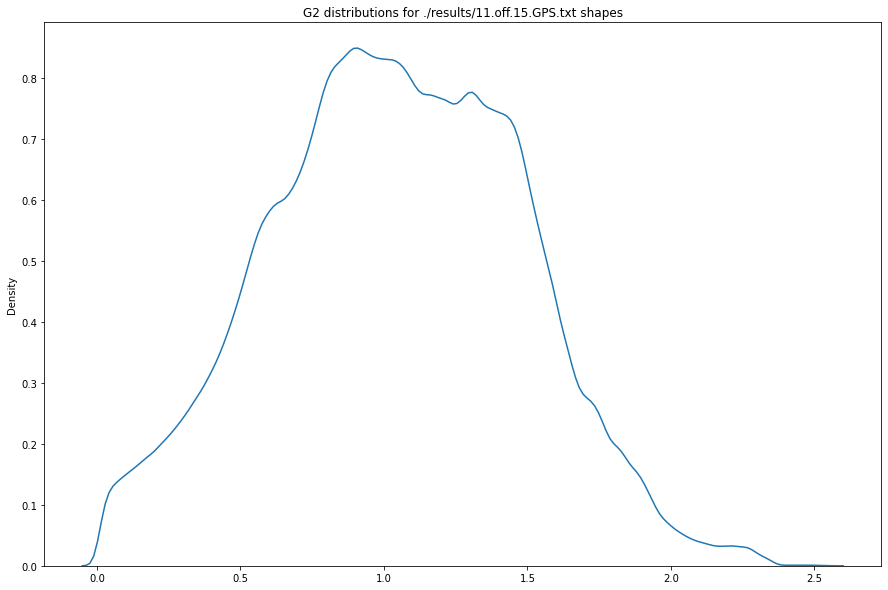

(6288, 15)
3556996


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


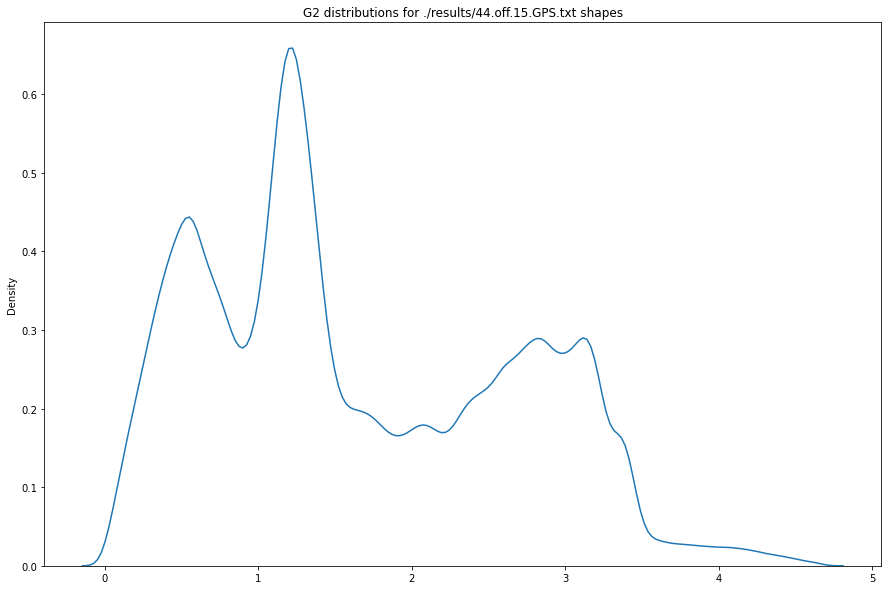

(7654, 15)
5267025


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


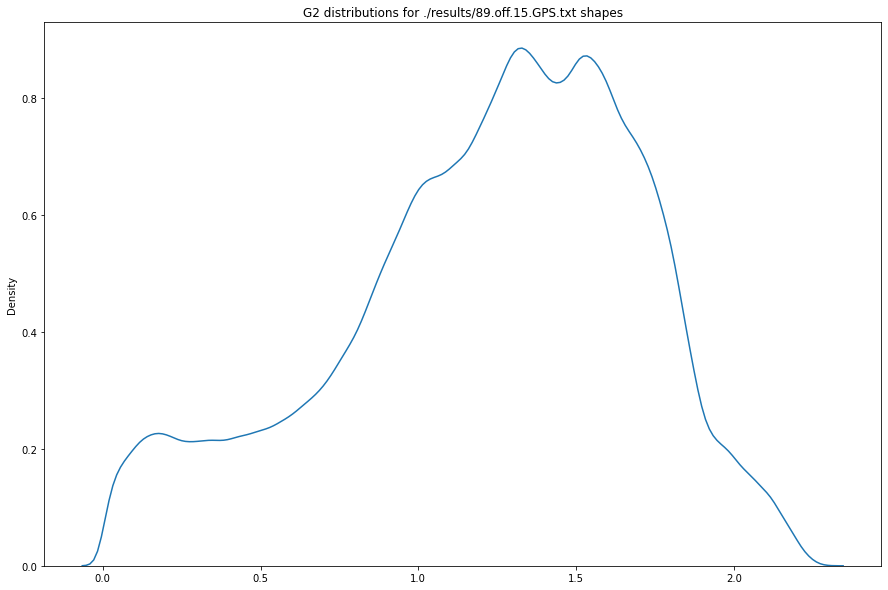

(6376, 15)
3655744


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


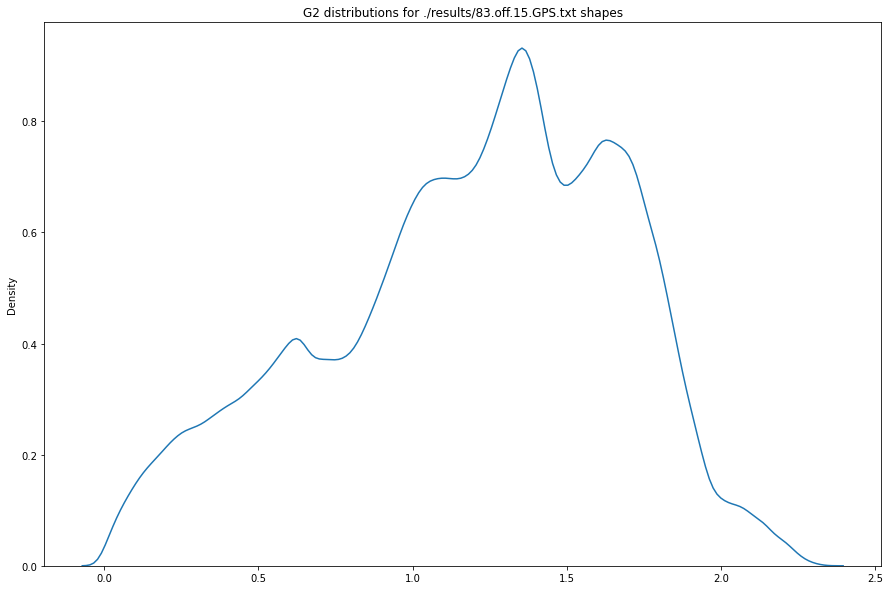

(8504, 15)
6502500


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


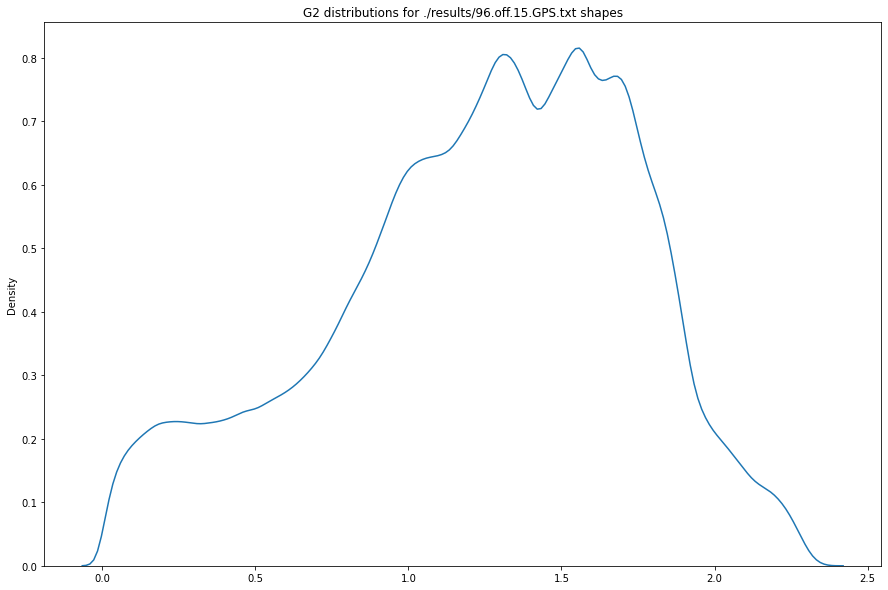

(5631, 15)
2852721


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


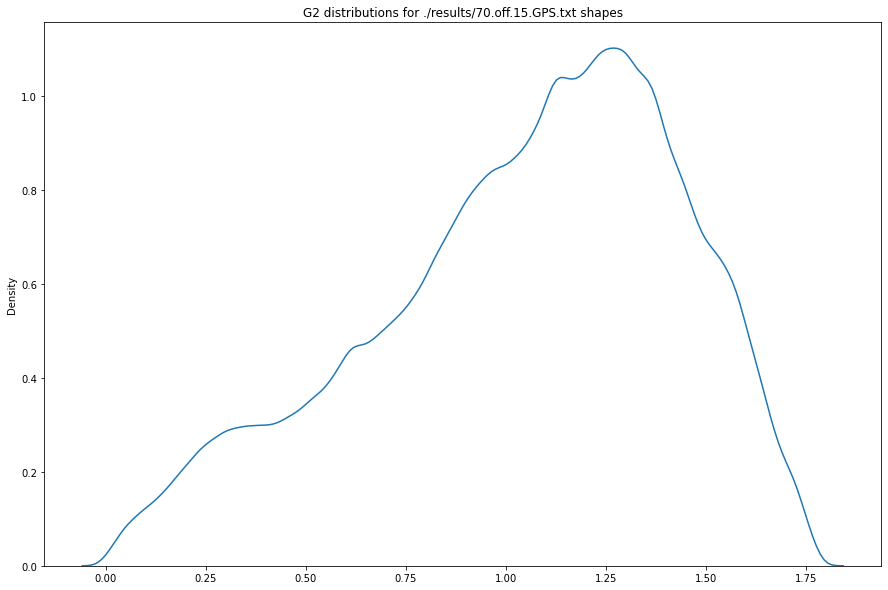

(8299, 15)
6195121


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


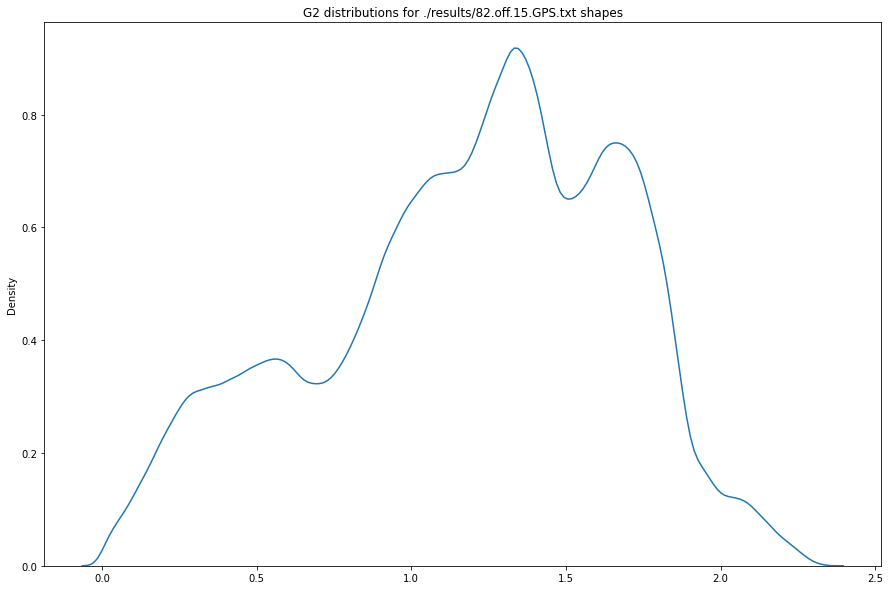

(8771, 15)
6922161


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


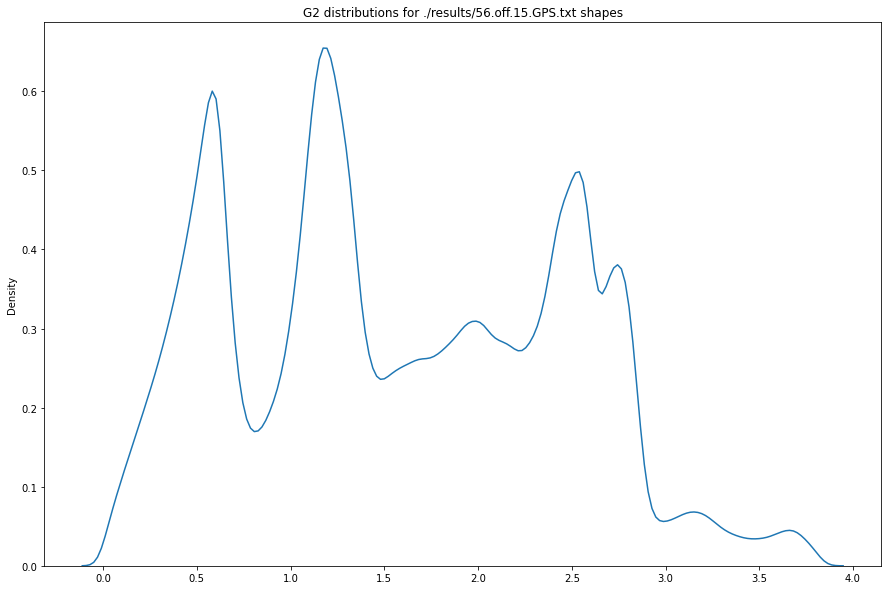

(5399, 15)
2621161


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


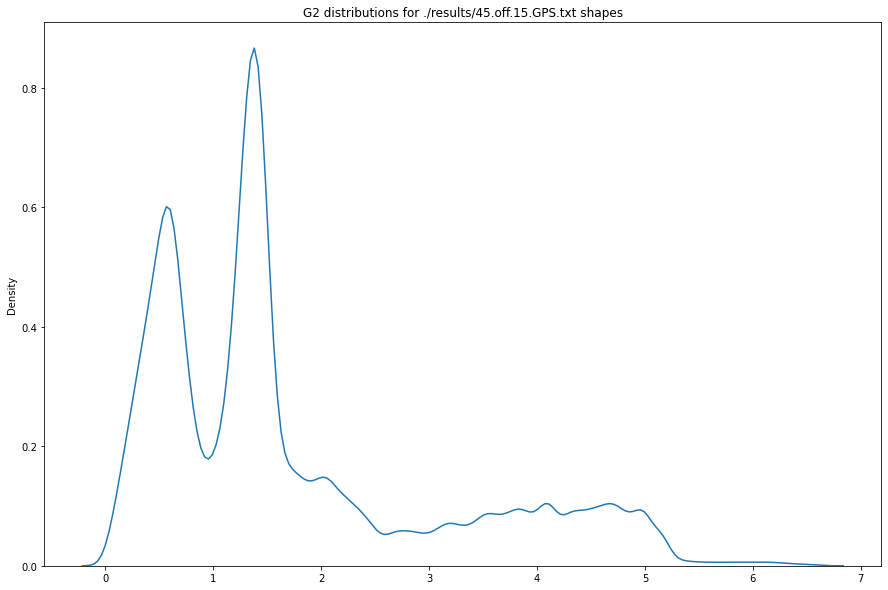

(2858, 15)
734449


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


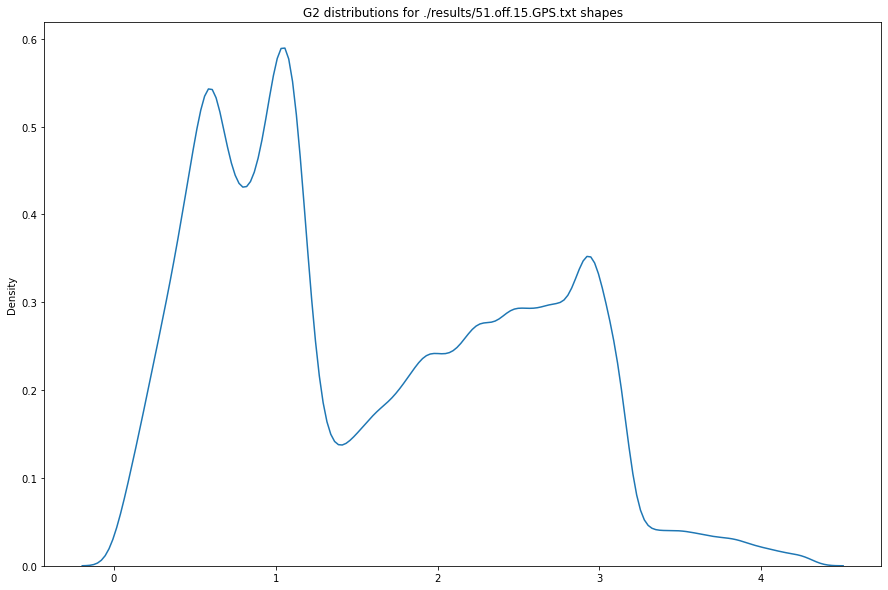

(2375, 15)
506944


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


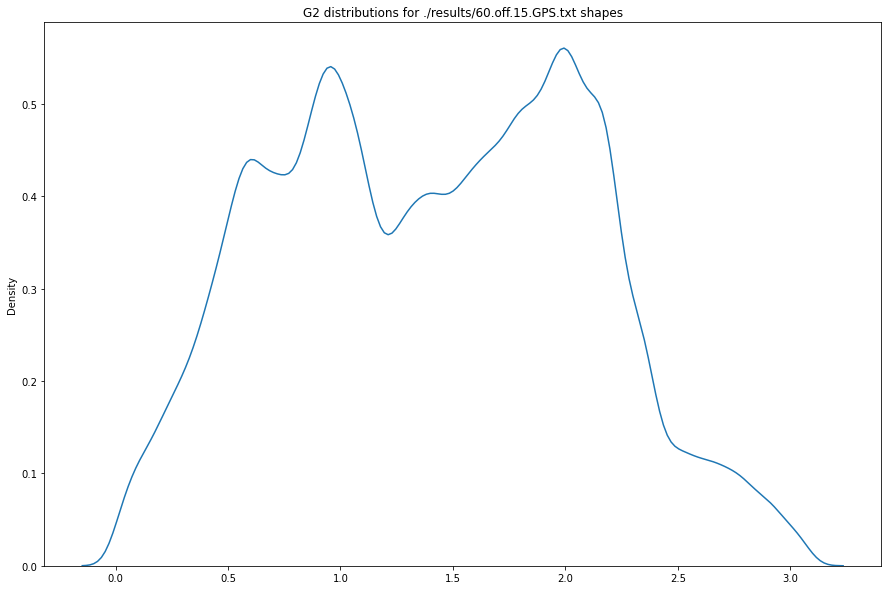

(7470, 15)
5017600


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


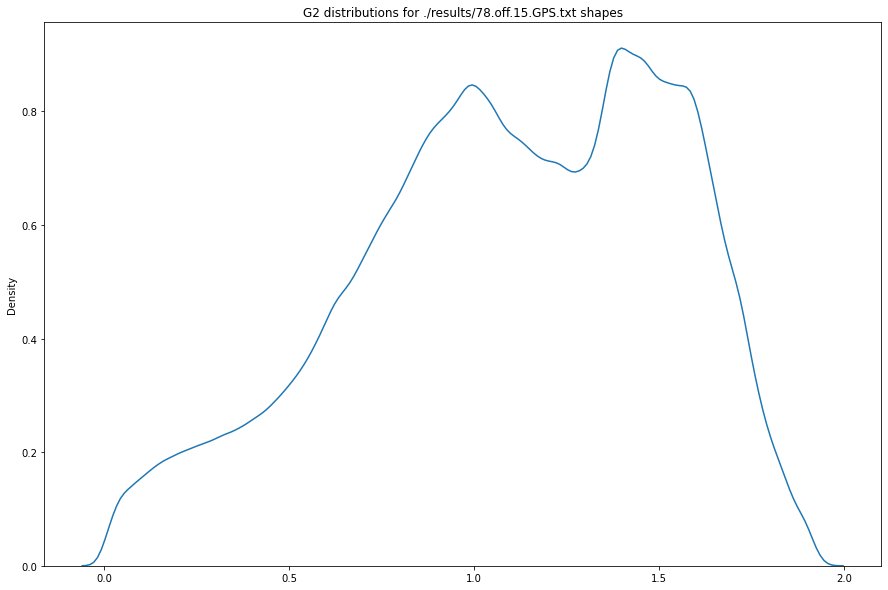

(8210, 15)
6061444


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


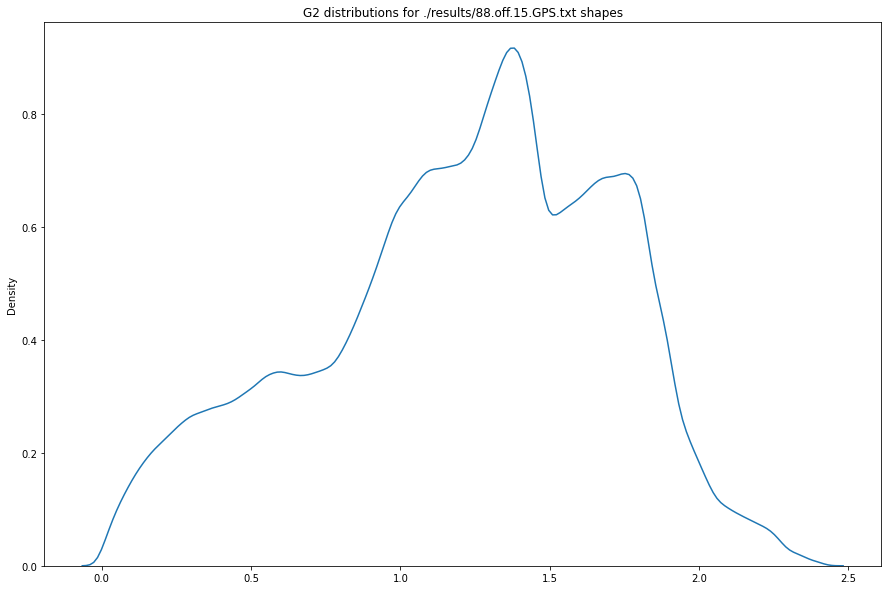

(2850, 15)
729316


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


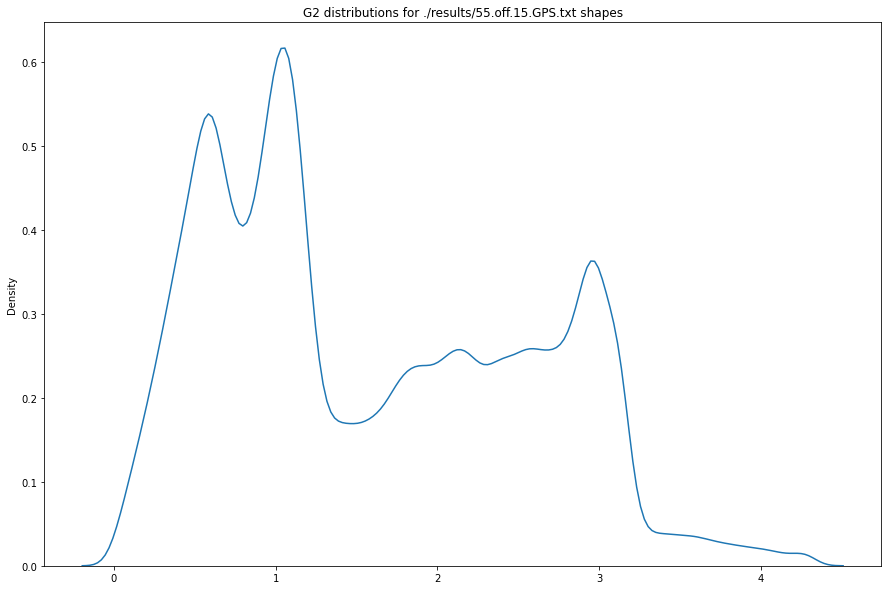

(15154, 15)
20657025


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


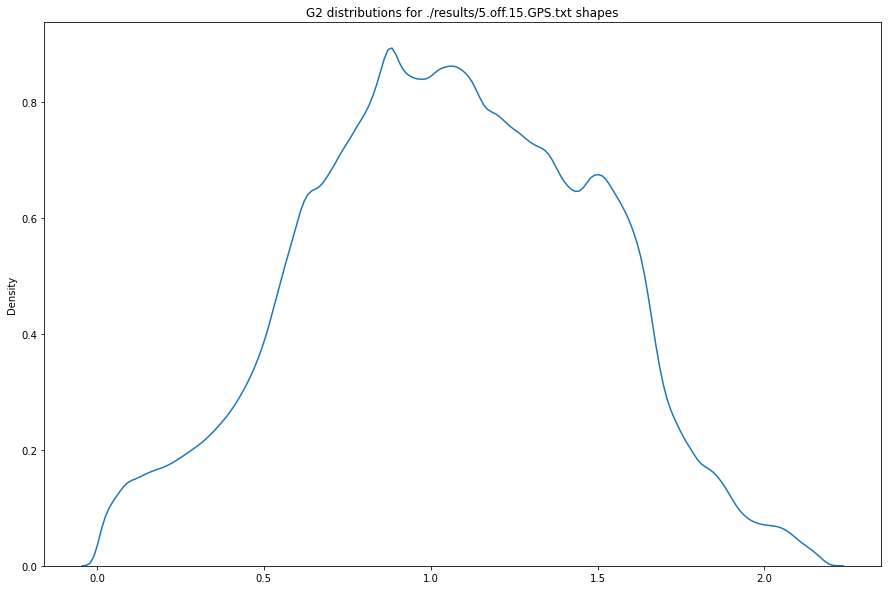

(6881, 15)
4260096


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


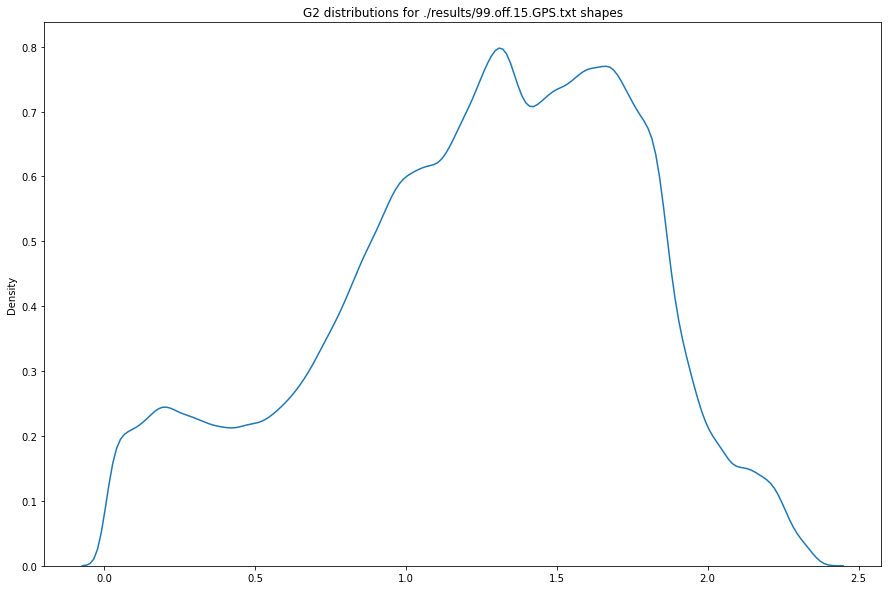

(7420, 15)
4950625


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


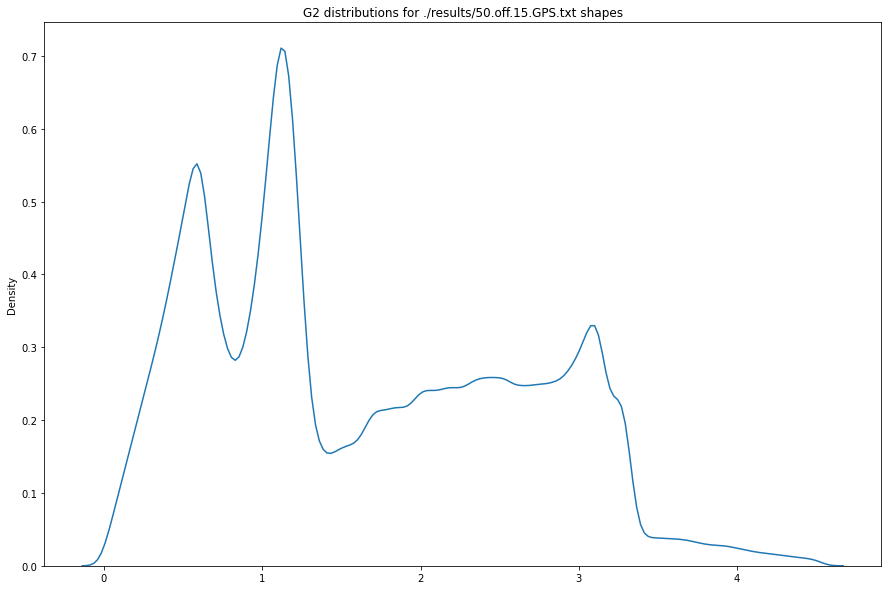

(2639, 15)
625681


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


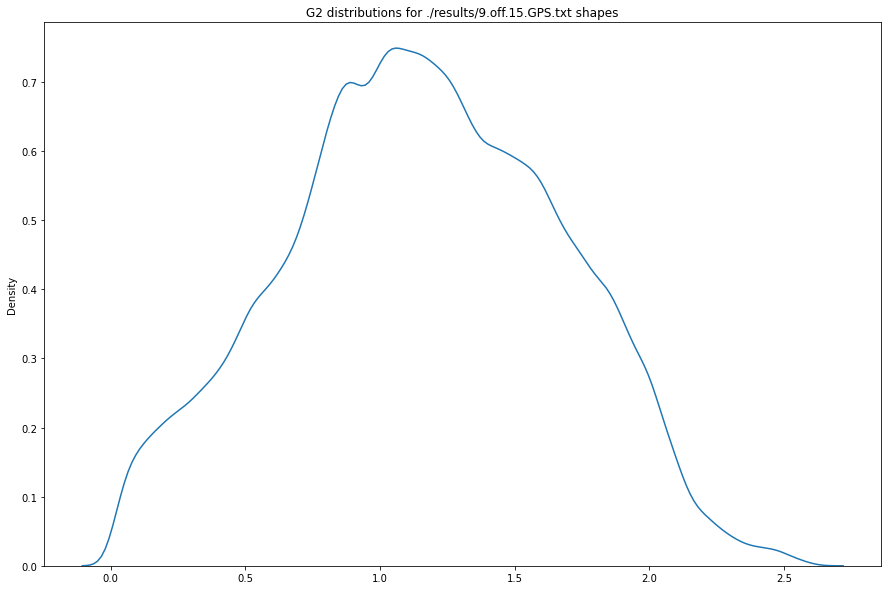

(15227, 15)
20857489


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


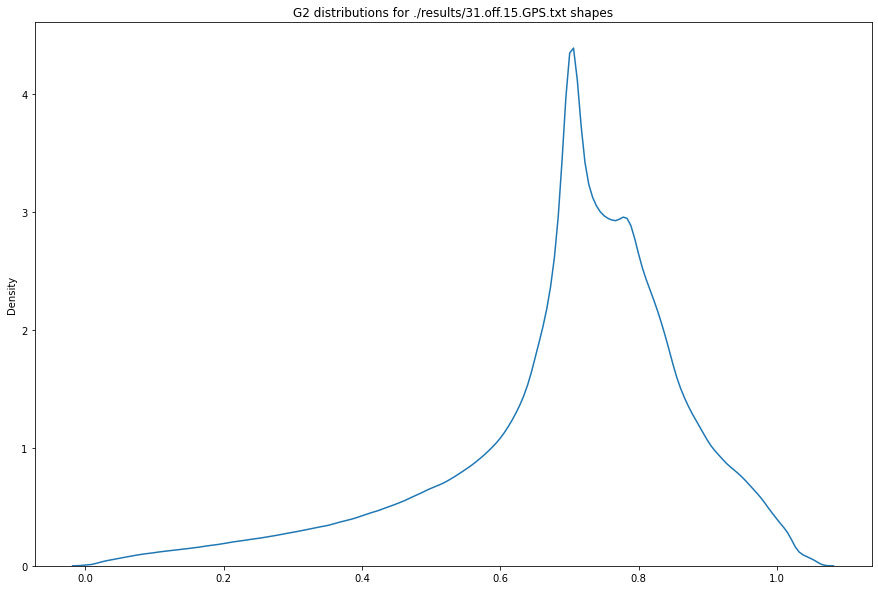

(5676, 15)
2896804


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


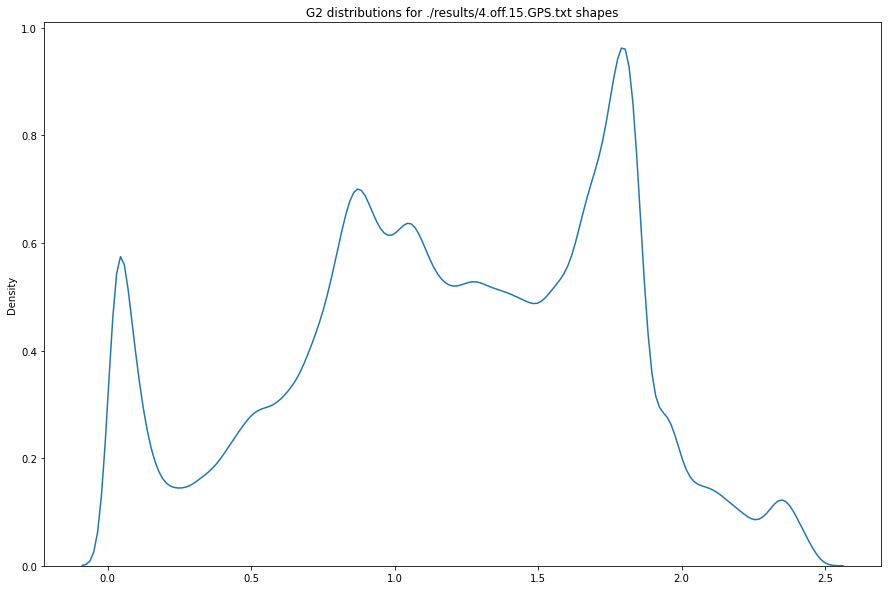

(7407, 15)
4932841


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


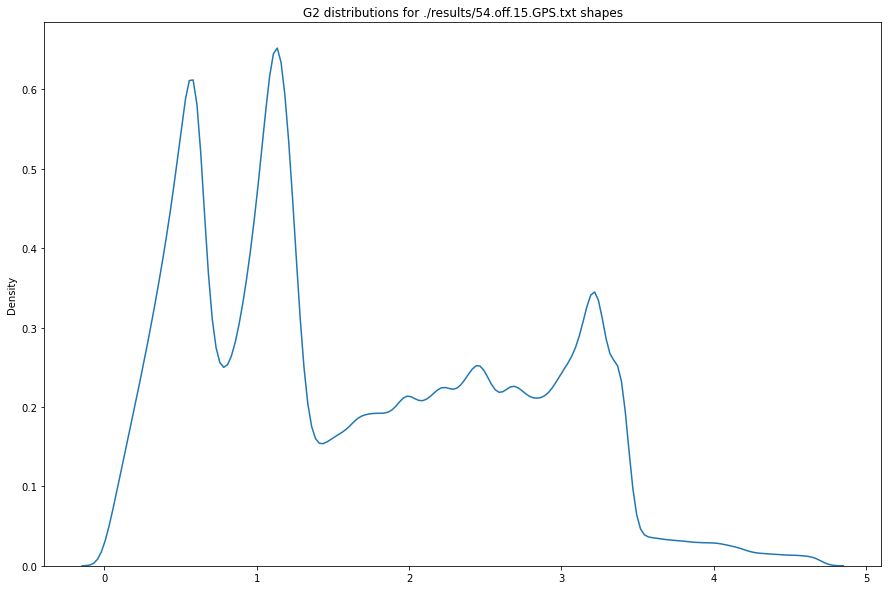

(1857, 15)
309136


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


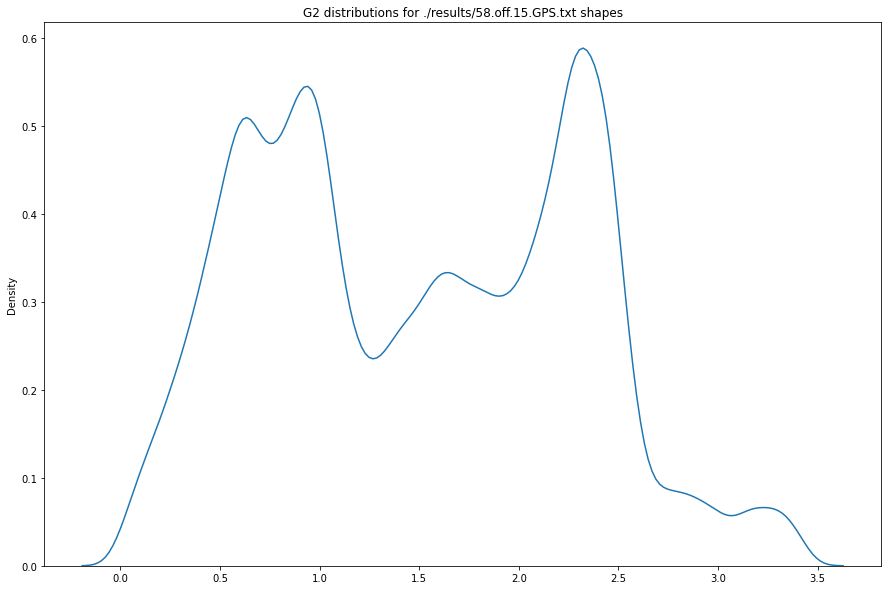

(5849, 15)
3076516


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


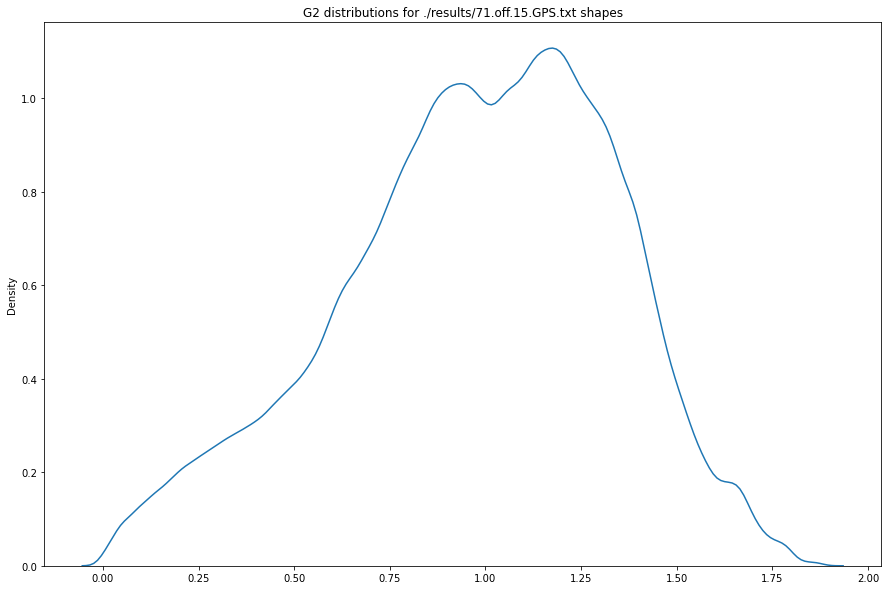

(5400, 15)
2621161


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


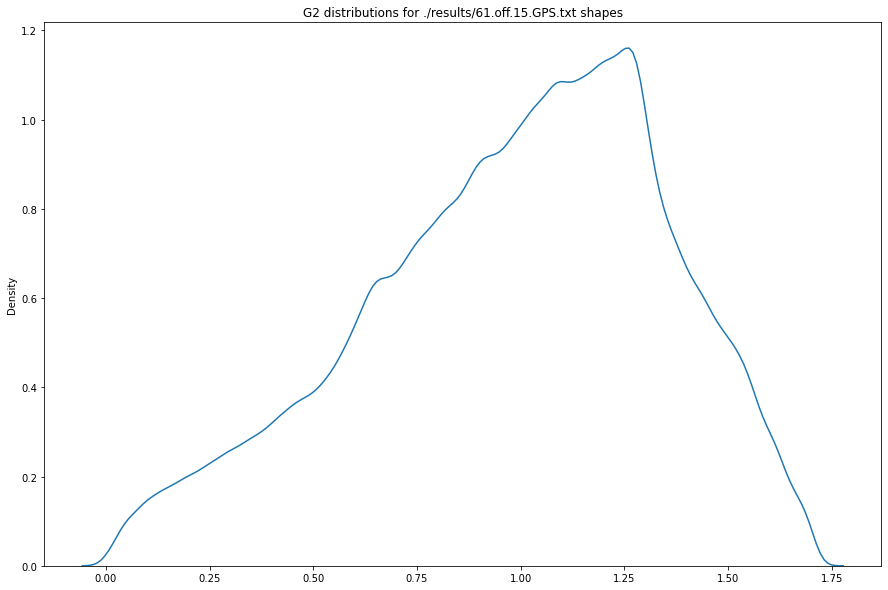

(5631, 15)
2852721


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


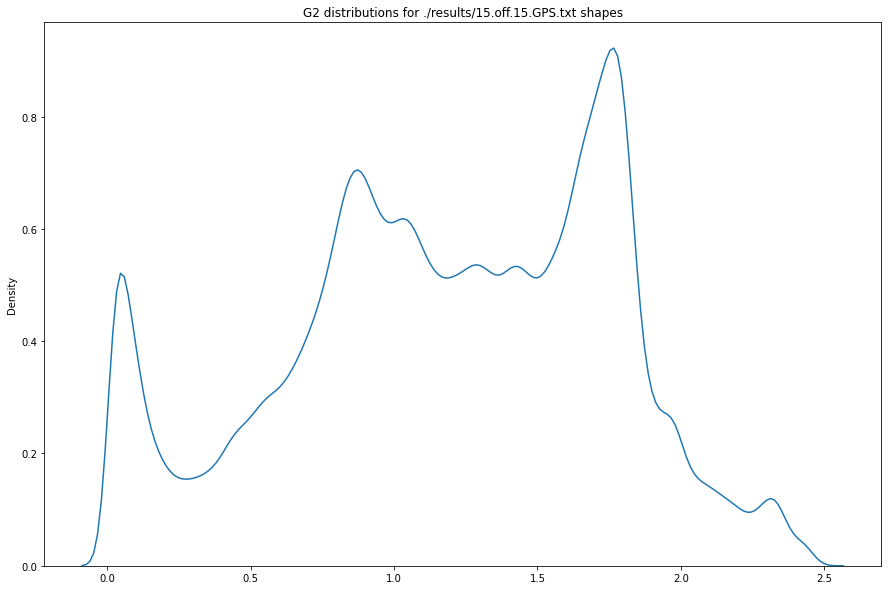

(5867, 15)
3094081


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


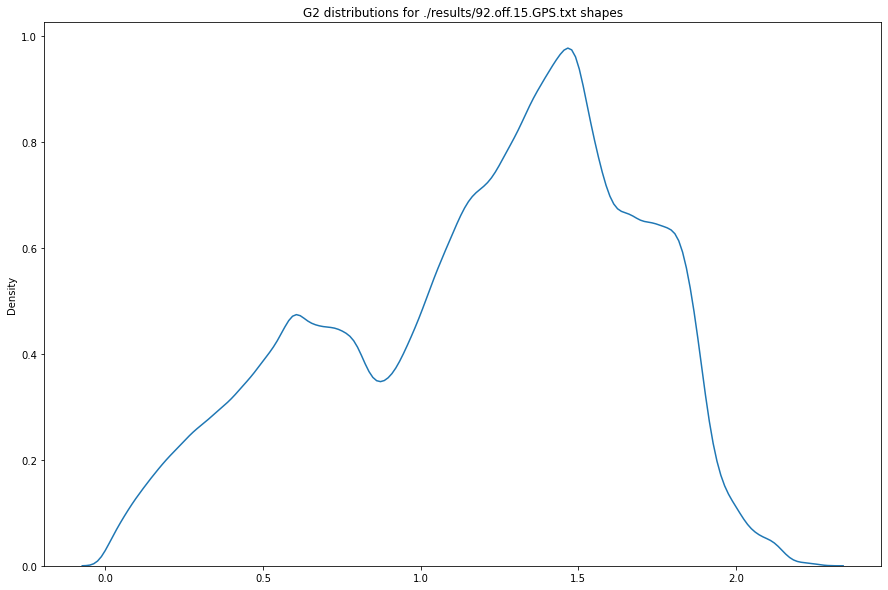

(8441, 15)
6411024


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


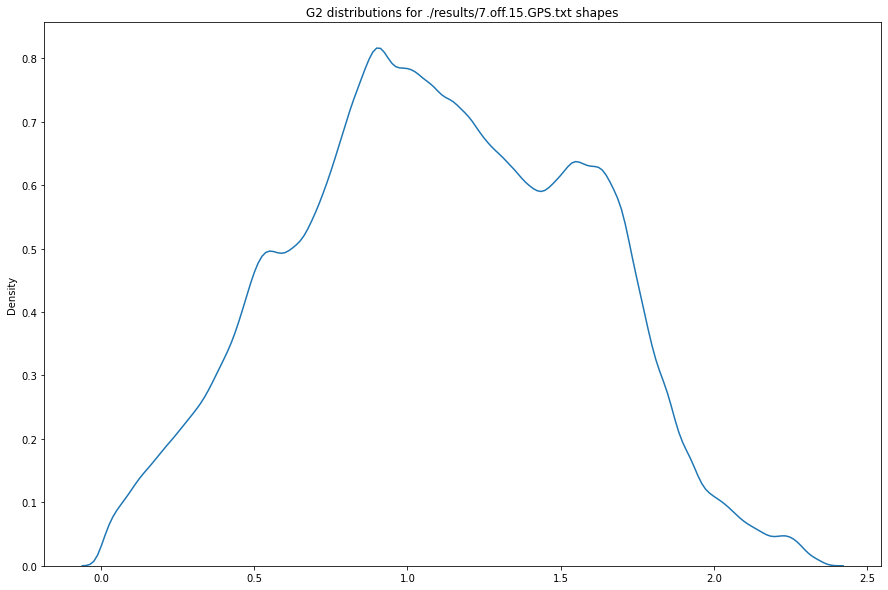

(6154, 15)
3404025


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


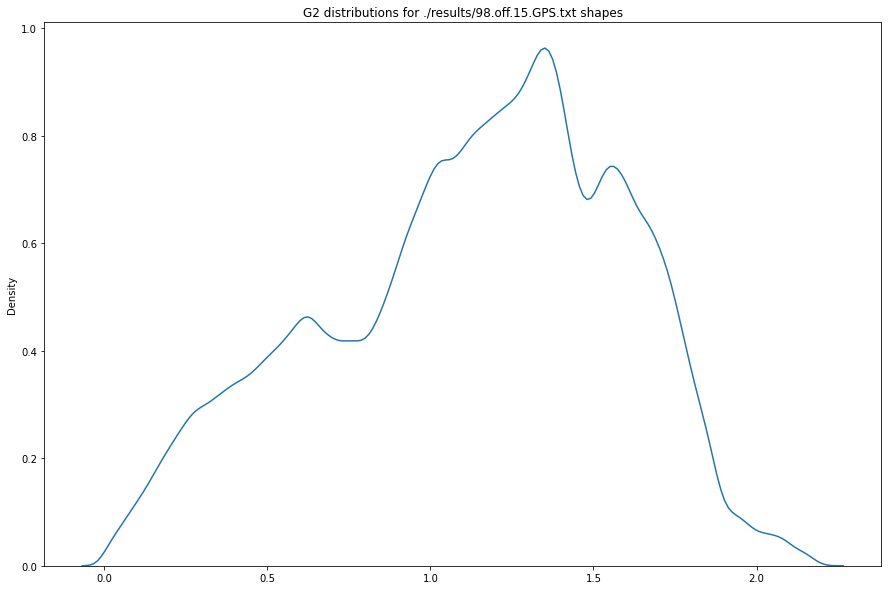

(4164, 15)
1557504


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


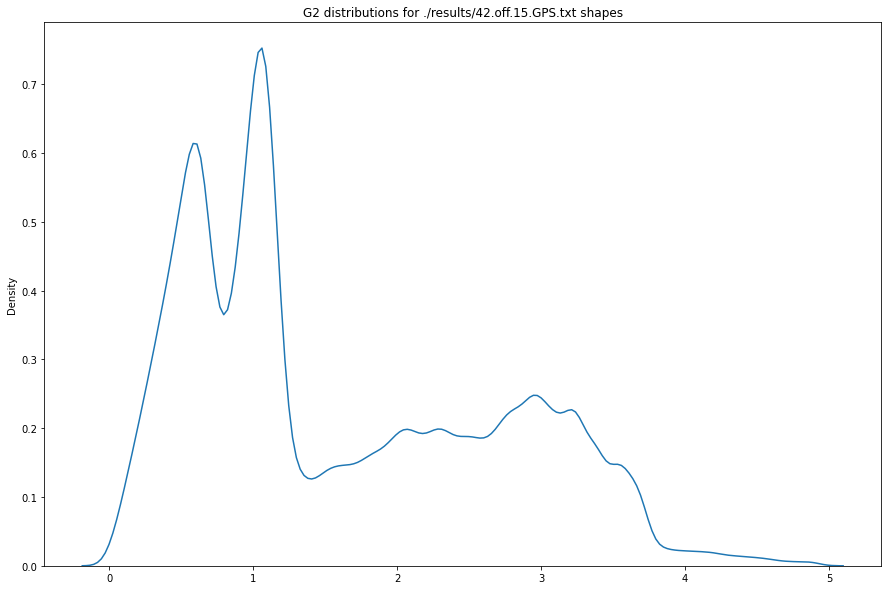

(3414, 15)
1046529


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


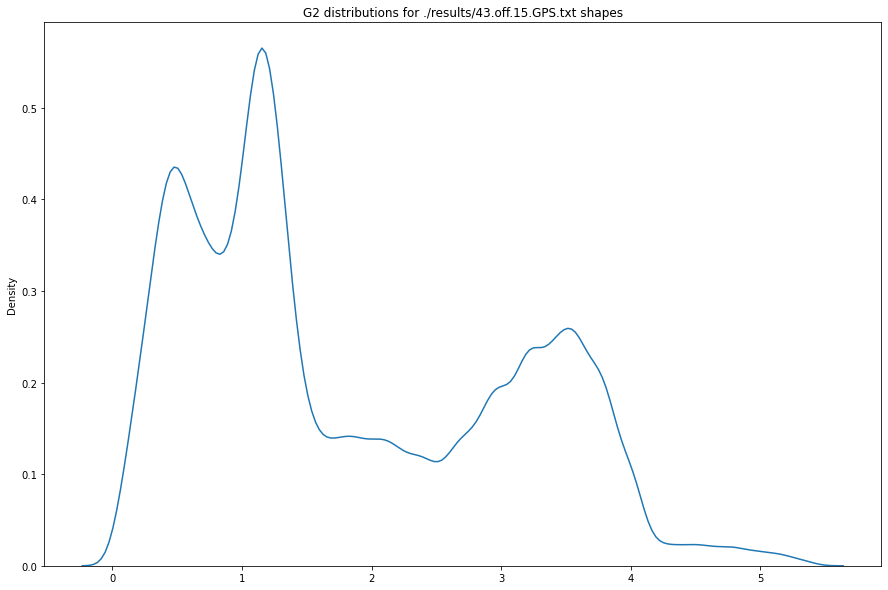

(2028, 15)
369664


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


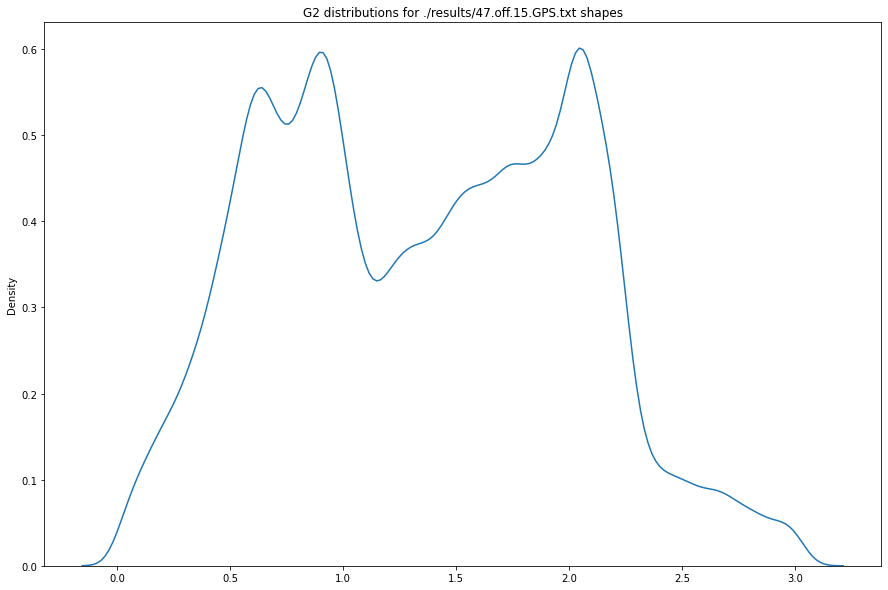

(5923, 15)
3154176


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


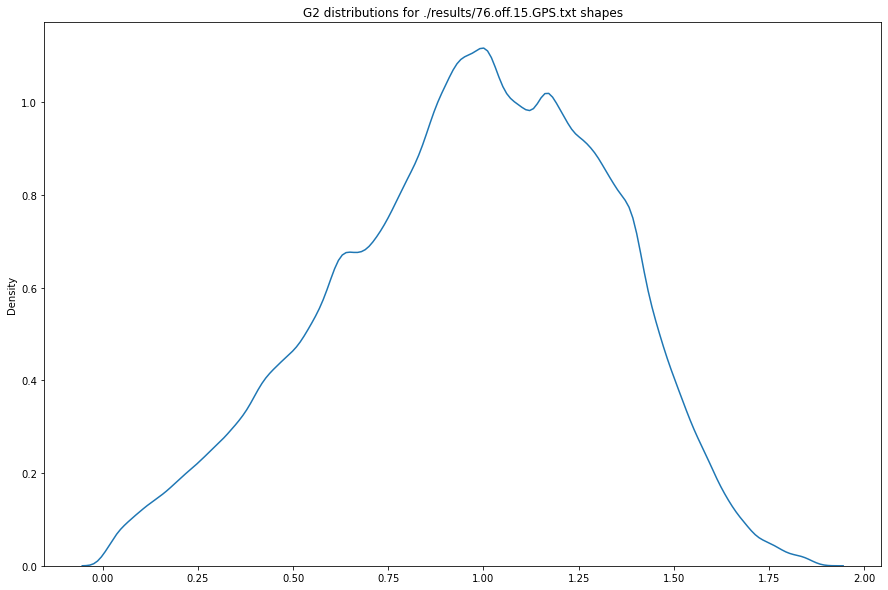

(1554, 15)
216225


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


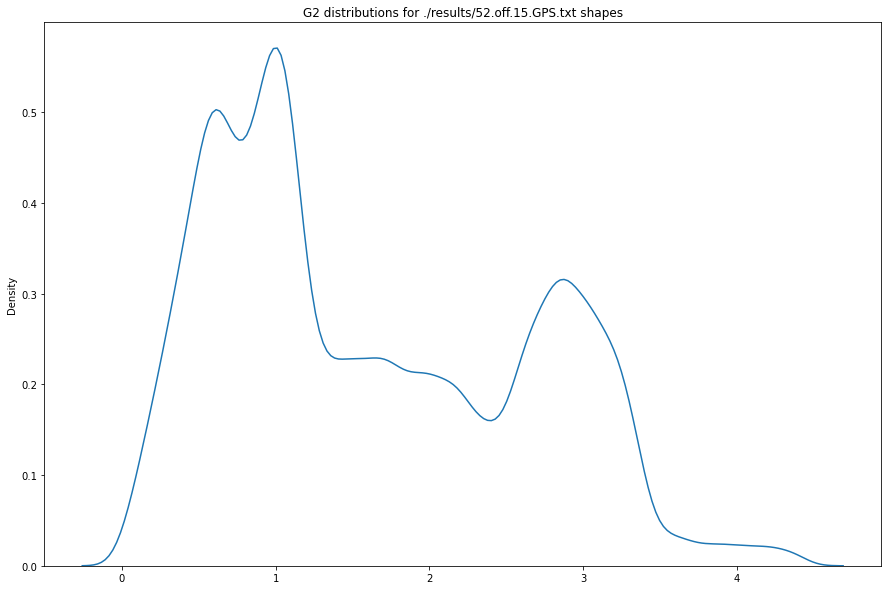

(10098, 15)
9174841


/Users/anandhu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


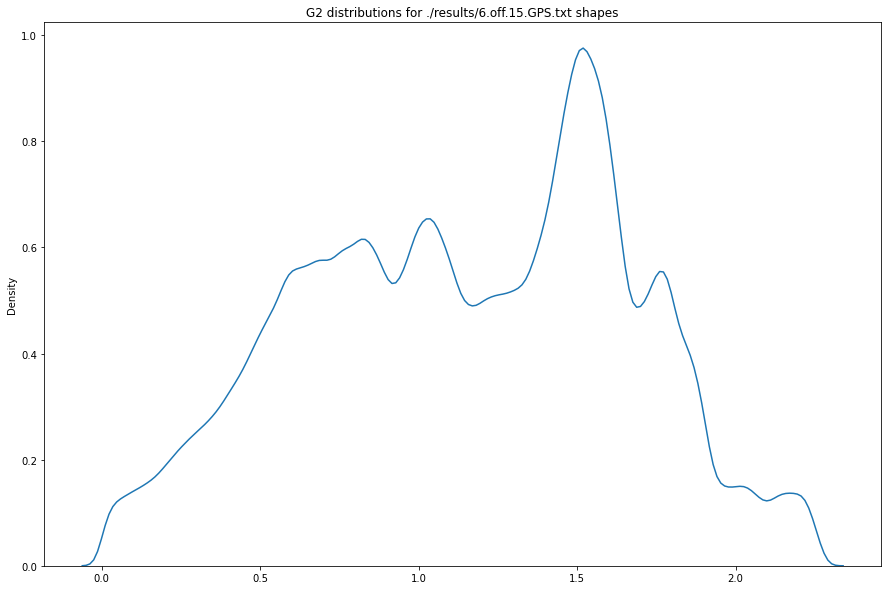

In [20]:
# Histograms per shape (m = 1)
m = 1
base_names = list(set([meshname.split('-')[0] for meshname in embeds_gps]))

for shape in base_names:
    plt.figure(figsize=(15, 10))
    for f in embeds_gps:
        if shape not in f:
            continue
        gps_i = matrixGPS(f)
        print(gps_i.shape)
        regs_i = regions(gps_i)
        di = distances(gps_i, regs_i, 0, 0)
        print(len(di))
        sns.distplot(di, hist=False, label=f)
    plt.title('G2 distributions for ' + shape +' shapes')
    plt.show()  

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


#### Visualizations of mean GPS signature

In [29]:
X = []
y_full = []
y_mid = []
y_simple = []
min_d = 20

int_table = str.maketrans(dict.fromkeys('0123456789'))
for f in embeds_gps:
    gps = matrixGPS(f)
    v = np.mean(gps, axis=0)
    print(v)
    X.append(v)
    if len(v) < min_d:
        min_d = len(v)
    meshname = name(f)
    y_full.append(meshname)
    y_simple.append(meshname.split('-')[0])
    y_mid.append(meshname.translate(int_table).strip('-').replace('-reference', '').split('--', 1)[0])
    
# truncate to maximum common spectrum depth
X_trunc = [x[:min_d] for x in X]
X_trunc = np.array(X_trunc)

print(X_trunc.shape)

[ 8.73217075e-04 -8.05247632e-03 -1.50651920e-04 -3.27482270e-04
 -7.44649008e-05  3.54305434e-05  3.99038027e-05  1.02224788e-04
  4.95851912e-04 -3.23568751e-05 -1.83784557e-04 -5.95285686e-05
  6.90660146e-04 -5.68775891e-05  1.56370910e-04]
[-2.07377340e-02 -1.68938307e-01  5.47301045e-03  1.82907091e-02
 -4.33061499e-04  1.10588264e-02 -1.97014892e-03  8.69242272e-03
 -2.73577556e-03  5.63154889e-03  1.73227393e-03  5.85303098e-05
  3.13221560e-04 -8.72574905e-04 -4.21900879e-04]
[-3.32371933e-03  1.96002624e-02  6.24940388e-04 -1.25637714e-03
  8.95915803e-05  1.82484255e-03 -4.17332322e-04  1.62110643e-03
  2.00040890e-03  2.04196193e-03  1.69057515e-03 -5.96151345e-04
 -1.78278442e-03  4.88533488e-04  2.83772223e-04]
[-6.93137649e-03 -7.62747538e-02  1.39339459e-03  1.24687028e-02
 -4.22183479e-03  5.75616246e-03  1.41547974e-03  7.93868227e-03
 -2.09840138e-03  1.19273902e-03  5.19678088e-04  3.83180806e-04
  6.63973550e-05  5.09875857e-04 -4.98637332e-04]
[ 3.10370452e-03  6.

[ 1.73556283e-02  2.14149873e-03 -1.73696034e-03 -2.31323973e-03
 -4.26828856e-04  8.35198999e-04 -4.53875489e-05  7.48506771e-03
 -3.76946288e-03  8.07011318e-04  2.42768669e-04 -7.16433454e-04
  1.66699770e-04 -9.91700835e-05 -1.71696709e-04]
[-1.68538118e-02 -1.42588940e-02  2.33990559e-03  1.77128875e-03
 -1.04712643e-03 -1.32246770e-03  1.73440648e-03 -1.04972479e-03
 -5.46515855e-03  3.63670391e-03 -1.41002319e-03  3.15422468e-04
  1.02758802e-05 -1.52125995e-04  4.23904373e-04]
[-0.01281339 -0.0010027   0.03427075  0.01254394  0.00384319 -0.00546908
 -0.005912   -0.00114511  0.00066051  0.00833724 -0.00790122  0.0026835
 -0.00302337  0.00055749 -0.00454693]
[-1.37479969e-02 -1.75114750e-02 -1.59670237e-03 -1.73148640e-04
 -5.87944418e-04 -8.01624195e-04 -4.97965169e-04  1.07488479e-02
  3.72077350e-03  1.74877280e-04  8.76696888e-04 -1.48760155e-04
  6.07924868e-05  2.07993478e-03 -1.11275266e-03]
[ 6.32435140e-03 -5.76364900e-05 -7.84307769e-03  8.47675255e-03
 -1.26845655e-03 

[ 6.69744932e-03  3.25998492e-04 -1.16208341e-02  1.07782855e-02
 -2.54020007e-04 -1.15257939e-03  3.95554398e-05  1.07167359e-04
 -2.78532293e-04  3.53338178e-04  2.86946662e-03 -4.44559849e-05
 -1.83382193e-03  9.16506646e-04 -1.81096611e-03]
[ 3.26021533e-02  3.05456131e-03  1.38471428e-03 -2.30276324e-02
  1.50054243e-03  1.80239995e-02  2.28550229e-03 -1.73855668e-03
  1.25351128e-03  3.51181559e-03  2.52135496e-05  4.97899100e-04
 -2.59365129e-03 -8.28273825e-03 -1.18150481e-03]
[-2.47069511e-02 -3.34735030e-03  5.06276289e-06  4.19603385e-02
  2.99006035e-01  8.36193589e-02  1.05421973e-03 -3.16159395e-02
 -4.11717196e-03  4.10645627e-05 -3.06402389e-02  1.47566297e-05
 -7.78100170e-03  2.21344377e-02 -8.02309117e-04]
[ 9.38278015e-03  2.14963631e-02  1.13668923e-03  5.94353794e-04
  3.69196493e-04 -1.30178191e-03  3.73472925e-03 -6.65299165e-04
 -5.71053108e-03 -2.85996413e-03  1.86590400e-03  9.23322209e-04
  8.37087440e-06 -5.50233899e-04  9.40667338e-05]
(79, 15)


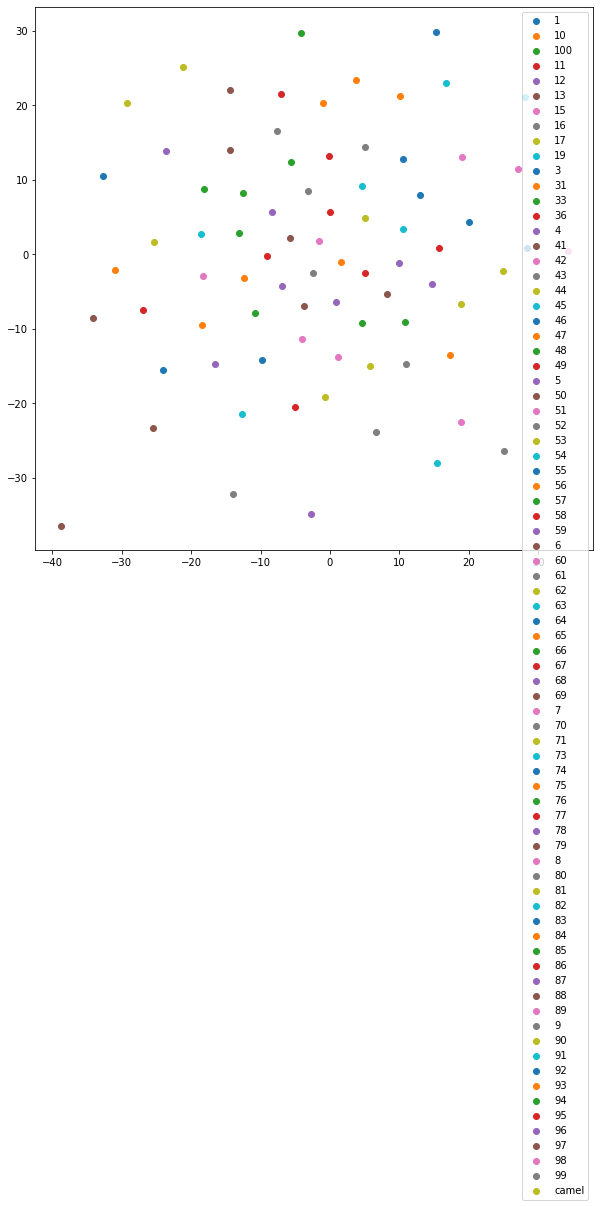

In [30]:
x_tsne, y_tsne = dim_reduction(X_trunc, method='tsne')
scatter_annotated(x_tsne, y_tsne, y_simple)

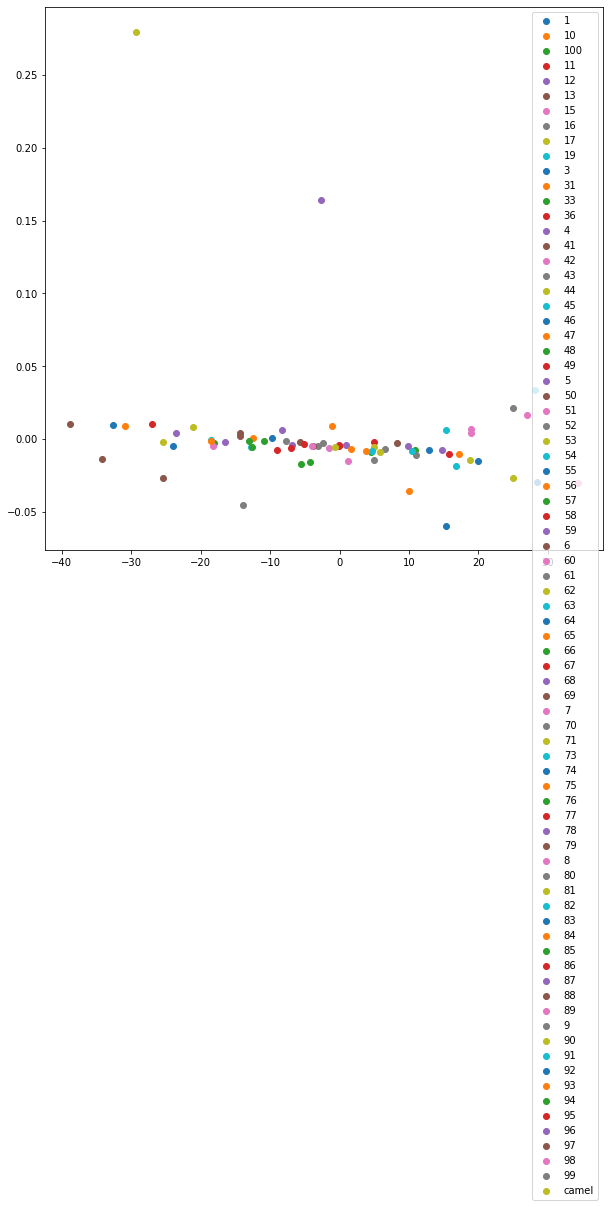

In [31]:
x_pca, y_tsne = dim_reduction(X_trunc, method='pca')
scatter_annotated(x_tsne, y_tsne, y_simple)

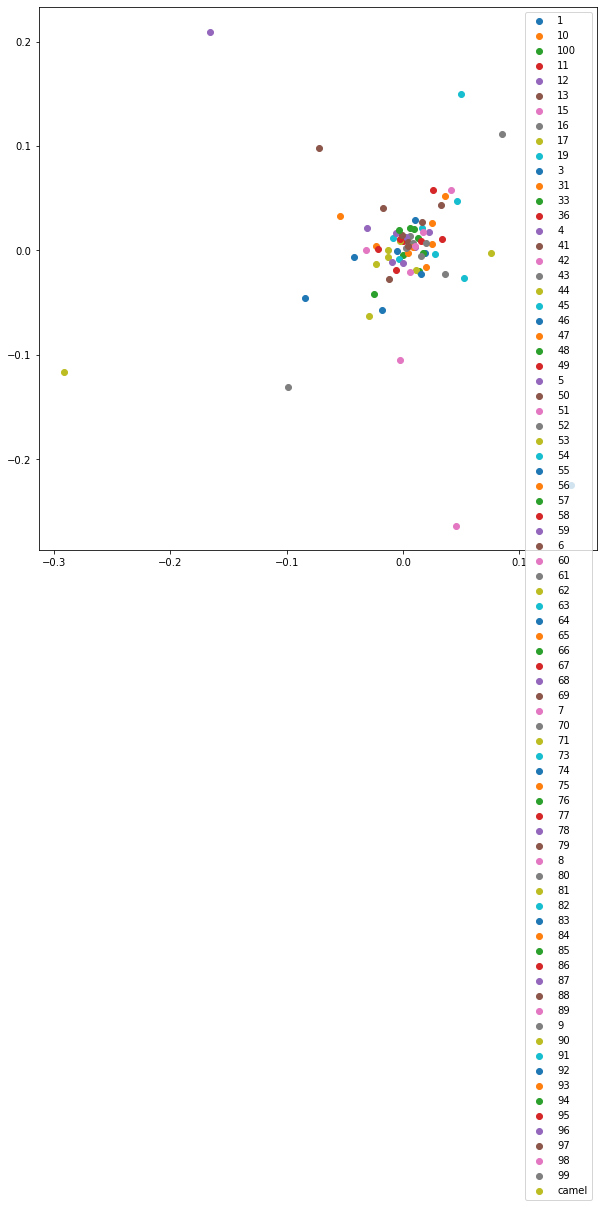

In [32]:
x_tsne, y_tsne = dim_reduction(X_trunc, method='mds')
scatter_annotated(x_tsne, y_tsne, y_simple)

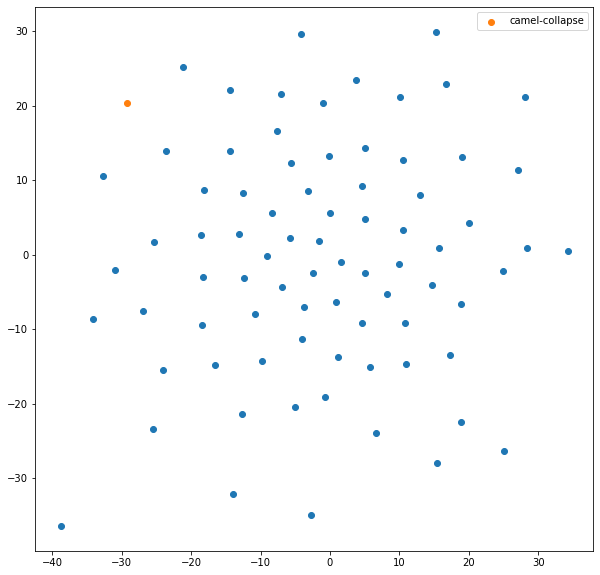

In [33]:
x_tsne, y_tsne = dim_reduction(X_trunc, method='tsne')
scatter_annotated(x_tsne, y_tsne, y_mid)

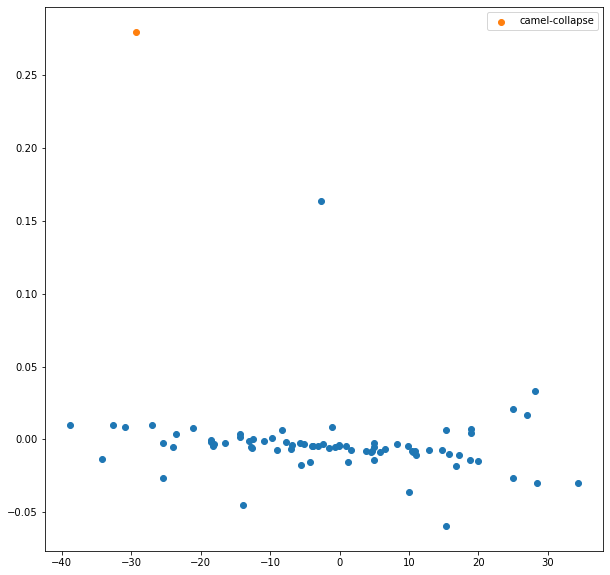

In [34]:
x_pca, y_tsne = dim_reduction(X_trunc, method='pca')
scatter_annotated(x_tsne, y_tsne, y_mid)

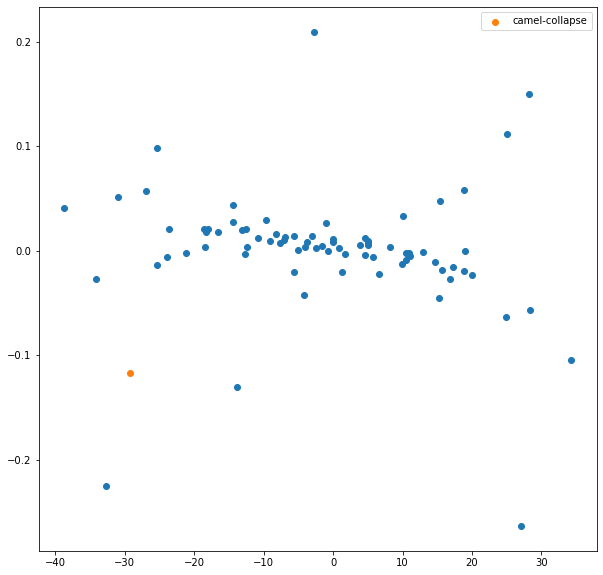

In [35]:
x_pca, y_tsne = dim_reduction(X_trunc, method='mds')
scatter_annotated(x_tsne, y_tsne, y_mid)